In [1]:
# Library for data manipulation
import pandas as pd
import numpy as np

# Library for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import missingno

# Library for statistics
from scipy.stats import normaltest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency

# Library for data preparation
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

#imbalanced 
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTEN, SMOTENC
from imblearn.under_sampling import RandomUnderSampler

#Library for modeling
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

#Libary for evaluation
from sklearn.metrics import  classification_report, RocCurveDisplay, confusion_matrix
from sklearn.metrics import recall_score, precision_score, roc_auc_score

#Library for deployment
import pickle

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [3]:
# function untuk cek outlier
def cek_outlier(df,col):
    rekap = pd.DataFrame()
    kolom = []
    Q1 = []
    Q3 = []
    IQR = []
    b_atas = []
    b_bawah = []
    jmlh = []
    index_outlier = []
    angka = 0
    
    for i in col:
        angka += 1
        q1 = df[i].quantile(0.25)
        q3 = df[i].quantile(0.75)
        iqr = q3-q1

        batas_bawah = q1 - 1.5*iqr
        batas_atas = q3 + 1.5*iqr

        hasil = df[(df[i] < batas_bawah) | (df[i] > batas_atas)]
        hitung = len(hasil)

        index_outlier.extend(df[(df[i] < batas_bawah) | (df[i] > batas_atas)].index)

        kolom.append(i)
        Q1.append(q1)
        Q3.append(q3)
        IQR.append(iqr)
        b_atas.append(batas_atas)
        b_bawah.append(batas_bawah)
        jmlh.append(hitung)
        
        if angka == len(df[col].columns):
            rekap['Kolom'] = kolom
            rekap['Q1'] = Q1
            rekap['Q3'] = Q3
            rekap['IQR'] = IQR
            rekap['Batas Atas'] = b_atas
            rekap['Batas Bawah'] = b_bawah
            rekap['Jumlah Outlier'] = jmlh
            rekap['Proporsi(%)'] = rekap['Jumlah Outlier']/len(df)*100

    return rekap.sort_values('Jumlah Outlier', ascending=False), index_outlier

# Function untuk mencari nilai Variance Inflation Factor
def vif(X) :
    vif = pd.DataFrame()
    vif['variabel'] = X.columns
    vif['vif'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]

    return vif

# Function untuk membuat fitur baru berdasarkan fitur pdays
def contact(pdays):
    if pdays == 999:
        return "not contacted"
    else:
        return "contacted"
    
# Function untuk membuat firur baru bardasarkan fitur age (keperluan analisis)    
def group_age(age):
    if age <= 24:
        return "early working age"
    if age <= 54:
        return "prime working age"
    if age <= 64:
        return "mature working age"
    else:
        return "elderly"   

# Table of Content
- Business Understanding & Problem Statement
- Data Uderstanding 
- Exploratory Data Analysis
- Data Preparation 
- Methodology (Data Analysis & Modeling)
- Kesimpulan & Rekomendasi
- Deployment

# Business Understanding & Problem Statement

**Business Understanding**

Banyak insturmen investasi yang dapat digunakan oleh masyarakat. Saham, obligasi, logam mulia, dan produk perbankan merupakan beberapa contoh insturmen investasi. Beberapa bank mengeluarkan produk investasi salah satu jenisnya adalah deposito. Berdasarkan keterangan dari [Bank HSBC](https://www.hsbc.co.id/1/PA_esf-ca-app-content/content/indonesia/personal/offers/news-and-lifestyle/files/articles/html/201908/kenali-perbedaan-tabungan-dan-deposito.html), deposito merupakan salah satu produk investasi yang hanya bisa diambil setelah jangka waktu tertentu. Dikutip dari [OJK](http://sikapiuangmu.ojk.go.id/FrontEnd/CMS/Article/252), deposito merupakan produk investasi perbankan dengan tingkat pengembalian lebih tinggi dibandingkan dengan tabungan, deposito umumnya dipilih sebagai instrumen investasi bagi investor dengan resiko profil rendah. Terdapat beberapa hal yang mempengaruhi suku bunga di suatu bank yaitu kebutuhan dana, persaingan antar bank, kebijakan pemerintah (suku bunga acuan), profit yang ingin didapatkan, dan jangka waktu [(Komunal, 2022)](https://depositobpr.id/blog/5-faktor-yang-mempengaruhi-naik-turunnya-suku-bunga-deposito).

Berdasarkan [Muchtar (2022)](https://klc2.kemenkeu.go.id/kms/knowledge/dari-manakah-bank-mendapatkan-keuntungan-07b79059/detail/), Bank mendapatkan keuntungan dari 2 sumber yaitu spread based income dan fee based income. Fee based income merupakan pendapatan yang didapat dari luar sumber utama jasa-jasa perbankan, salah satu contohnya adalah biaya admin. Spread based income merupakan pendapatan utama dari bank, pendapatan ini diperoleh dari selisih antara bunga simpanan dengan bunga pinjaman/kredit. Bunga simpanan adalah balas jasa dari bank kepada nasabah atas jasa nasabah menyimpan uangnya di bank, sedangkan bunga pinjaman adalah balas jasa yang ditetapkan bank kepada peminjam atas pinjaman yang didapatkan.

Telemarketing merupakan pemasaran langsung barang atau jasa kepada calon pelanggan melalui telepon atau internet [(Kenton, 2022)](https://www.investopedia.com/terms/t/telemarketing.asp). Memprioritaskan, menyasar, dan memilih calon pelanggan dengan karakteristik tertentu terhadap produk yang ditawarkan merupakan salah satu cara untuk meningkatkan efisiensi dan keberhasilan telemarketing [(Azhar, 2012)](https://medium.com/@aifakhri/predicting-call-success-of-bank-telemarketing-campaign-with-machine-learning-4db3cf604d0a). Keberlangsungan proses telemarketing perlu diperhatikan, hal tersebut dikarenakan ada biaya yang diperlukan dalam menjalankan telemarketing. Dikutip dari [Magellan Sollutions](https://www.magellan-solutions.com/blog/cost-of-telemarketing/), perusahaan di US rata-rata menghabiskan biaya 20-75 dolar per jam dalam melakukan telemarketing 

**Context**

Perusahaan finansial berbentuk bank di Portugal memerlukan tambahan dana kelolaan untuk disalurkan kepada peminjam sehingga diharapkan dapat meningkatkan pendapatan perusahaan. Salah satu cara untuk menambahkan dana kelolaan adalah dengan cara nenawarkan produk investasi. Produk investasi bank diharapkan dapat menarik nasabah untuk lebih banyak menyimpan uangnya di bank sehingga dapat meningkatkan dana kelolaan bank. Salah satu produk investasi yang telah dimiliki adalah deposito. Bank menawarkan produk deposito dengan melakukan campaign telemarketing. 

**Problem Statement**

Proses penawaran produk deposito kepada calon nasabah dengan campaign telemarketing **tidak selalu** mendapatkan nasabah yang ingin membuka akun deposito, hal tersebut mengindikasikan bank perlu meningkatkan efisiensi dalam proses campaign telemarketing produk deposito. Hal tersebut dilakukan supaya lebih memprioritaskan nasabah yang cenderung akan membuka deposito, sehingga diharapkan dapat meningkatkan dana kelolaan bank serta diharapakan dapat meminimalisir biaya operasional campaign telemarketing.

**Goals**

Berdasarkan permasalahan di atas, **perusahaan ingin bisa memprediksi calon nasabah mana yang cenderung akan membuka akun deposito**, sehingga campaign telemarketing dapat **berjalan lebih efisien** dengan menargetkan atau memprioritaskan calon nasabah yang lebih berpotensi. Campaign telemarketing yang efisien dapat lebih **memaksimalkan tambahan dana kelolaan** sehingga bisa disalurkan kepada peminjam dan meningkatkan keuntungan serta diharapkan dapat **meminimalisir biaya operasional** campaign telemarketing.

**Analytic Approach**

Untuk mecapai tujuan di atas, kita dapat menganalisis karakteristik calon nasabah mana yang berpotensi akan membuka akun deposito, kemudian membangun model machine laearning (supervised learning) khususnya klasifikasi untuk memprediksi calon nasabah mana yang cenderung akan membuka akun deposito, sehingga calon nasabah tersebut dapat dijadikan prioritas dalam campaign telemarketing, sehingga proses tersebut berjalan lebih efisien.

**Metric Evaluation**

1 =  nasabah membuka deposito
<br>
0 =  nasabah tidak membuka deposito

- True Negative(TN) = Sebenarnya calon nasabah **tidak** membuka deposito, dan diprediski oleh model cenderung **tidak** membuka deposito
- False Negative(FN) = Sebenarnya calon nasabah membuka deposito, namun diprediksi oleh model cenderung **tidak** membuka deposito
- True Positive(TP) = Sebenarnya calon nasabah membuka depostio, dan diprediksi oleh model cenderung membuka deposito
- False Positve(FP) = Sebenarnya calon nasabah **tidak** membuka deposito, namun diprediksi oleh model cenderung membuka deposito

FP dan FN merupakan bentuk error yang dihasilkan oleh model, setiap error memiliki dampaknya terhadap bisnis. Dampak dari error dapat dilihat sebagai berikut:
- FP mengakibatkan perusahaan mengeluarkan sumber daya untuk campaign telemarketing yang sia-sia
- FN mengakibatkan perusahaan kehilangan calon nasabah yang akan membuka deposito, padahal cenderung sulit untuk bisa mendapatkan nasabah yang membuka deposito.

Oleh karena itu kita harus menggunakan metrik evaluasi yang mementingkan kedua kelas, salah satu metrik evaluasi yang dapat digunakan untuk kepentingan tersebut adalah ROC AUC. Metrik ROC AUC melihat kedua kelas sama pentingnya.

# Data Understanding

**Informasi Data**

Dataset berasal dari [Kaggle](https://www.kaggle.com/datasets/volodymyrgavrysh/bank-marketing-campaigns-dataset) penjelasan lengkapnya dapat dilihat di [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/222/bank+marketing). Dataset ini merupakan data histori dari telemarketing bank portugal sejak Mei 2008 hingga November 2010. Setiap baris data merepresentasikan nasabah yang telah dihubungi untuk ditawarkan deposito bank.

**Data client bank**
|No|Nama Variabel|Deskripsi|Jenis|
|---|---|---|---|
|1|age|umur nasabah|numerik
|2|job|jenis pekerjaan nasabah|kategorik (nominal)
|3|marital|status perkawinan|kategorik (nominal)
|4|education|jejang pendidikan|kategorik (ordinal)
|5|default|status gagal bayar pinjaman|kategorik (nominal)
|6|housing|status memiliki pinjaman rumah|kategorik (nominal)
|7|loan|status memiliki pinjaman pribadi|kategorik (nominal)

**Data berkaitan keterangan waktu kontak terakhir campaign terkini**
|No|Nama Variabel|Deskripsi|Jenis|
|---|---|---|---|
|8|contact|jenis komunikasi yang digunakan|kategorik (nominal)
|9|month|bulan akhir dikontak|kategorik (ordinal)
|10|day_of_week|hari akhir dikontak|kategorik (ordinal)
|11|duration|durasi waktu kontak (detik)|numerik

**Data berkaitan dengan campaign**
|No|Nama Variabel|Deskripsi|Jenis|
|---|---|---|---|
|12|campaign|jumlah kontak yang dilakukan pada campaign terkini|numerik
|13|pdays|selisih hari waktu kontak antara campaign terdahulu dan campaign terkini|numerik
|14|previous|jumlah kontak yang dilakukan pada campaign terdahulu|numerik
|15|poutcome|hasil campaign terdahulu|kategorik (nominal)

**Data berkaitan dengan indeks sosial dan ekonomi**
|No|Nama Variabel|Deskripsi|Jenis|
|---|---|---|---|
|16|emp.var.rate|indeks employment variation rate - quarterly indicator|numerik
|17|cons.price.idx|indeks consumer price - monthly indicator|numerik
|18|cons.conf.idx|indeks consumer confidence - monthly indicator|numerik
|19|euribo3m|Euribor rate|numerik
|20|nr.employed|jumlah rata-rata pekerja - quartley indicator|numerik
|21|y|hasil campaign terkini, status deposito nasabah|kategorik (nominal)

- Dikutip dari [Quora](https://www.quora.com/What-is-meant-by-employment-variation-rate-Does-it-affect-in-any-way-the-financial-decisions-that-an-individual-takes), **Employment variation rate** merupakan indikator yang memperlihatkan seberapa banyak orang yang menganggur berdasarakan kondisi ekonomi.

- **Consumer Price Index (CPI)** adalah alat ukur untuk menilai perubahan harga rata-rata suatu barang dan jasa, nilai CPI digunakan untuk mengukur tingkat inflasi yang terjadi [(OCBC, 2023)](https://www.ocbcnisp.com/id/article/2023/02/15/consumer-price-index-adalah#:~:text=Apa%20itu%20Consumer%20Price%20Index%3F,perubahan%20harga%20pada%20setiap%20barang.).

- Menurut [Setiyo](https://www.ajarekonomi.com/2016/10/consumer-confidence-index-cci-dan.html), **Consumer Confidence Index (CCI)** merupakan indikator utama dalam menilai kinerja perkonomian, khususnya mengenai tingkat konsumsi masyarakat.  CCI didasarkan pada apabila konsumen optimis, mereka akan berbelanja lebih banyak dan lebih menstimulus perkonomian, namun jika pesimis maka pola berbelanja akan menurun dan menyebabkan pertumbuhan ekonomi menurun sehingga dapat menyebabkan resesi ekonomi [(Ganti, 2023)](https://www.investopedia.com/terms/c/cci.asp).

- Dikutip dari [CRMS](https://crmsindonesia.org/glosarium/euro-interbank-offered-rate-euribor/), **Euribor** (Euro Interbank Offered rate) adalah suku bunga rata-rata yang ditawarkan oleh bank untuk dipinjamkan dalam bentuk pinjaman tanpa jaminan kepada bank lainya pada pasar uang euro. 

Berdasarkan tujuan perusahaan, dimana perusahaan ingin dapat memprediksi nasabah mana yang cendurung membuka deposito, maka variabel `y` akan dijadikan target variabel sedangkan variabel lainnya menjadi fitur. Namun perlu diperhatikan terdapat variabel yang hanya dapat diketahui setelah nasabah dikontak atau ditawari produk deposito, variabel tersebut adalah `duration`, sehingga tidak relevan apabila variabel tersebut dijadikan fitur dalam membangun model prediksi telemarketing, namun masih bisa menjadi bahan untuk dianalisis. Pemilihan fitur nanti akan dilanjut pada tahap data preparation.

# EDA

In [4]:
df= pd.read_csv('Dataset - bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
# merubah nama kolom untuk menyamaratakan format penamaan kolom

df.rename(columns={'emp.var.rate': 'emp_var_rate',
                   'cons.price.idx': 'cons_price_idx',
                   'cons.conf.idx': 'cons_conf_idx',
                   'nr.employed': 'nr_employed',
                   'y': 'target'}, inplace= True)

# merubah bentuk data target, untuk mempermudah saat melihat confusion matrix nantinya
df['target'].replace({'yes': 1, 'no':0}, inplace=True)


In [6]:
df_dupli = df[df.duplicated()]
df_dupli

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,target
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,124,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,0
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,331,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,43,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,128,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0
20216,55,services,married,high.school,unknown,no,no,cellular,aug,mon,33,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,0
20534,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,127,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,0
25217,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,123,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,0
28477,24,services,single,high.school,no,yes,no,cellular,apr,tue,114,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,0
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,348,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0


In [7]:
print(f'Jumlah data duplikat sebanyak {len(df_dupli)}, dengan persentase sebesar {round(len(df_dupli)/len(df)*100,2)}%')

Jumlah data duplikat sebanyak 12, dengan persentase sebesar 0.03%


Untuk mempermudah proses ekplorasi data, data duplikat dibuang terlebih dahulu karena takutnya akan mempengaruhi perhitungan distribusi serta outlier

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp_var_rate    41176 non-null  float64
 16  cons_price_idx  41176 non-null  float64
 17  cons_conf_idx   41176 non-null 

Berdasarkan pengecekan di atas, dapat dilihat bahwa tipe data beragam serta tidak terdapat data kosong.

## Varibel Target

Pada tahapan ini kita akan melihat proposi kelas pada variabel target.

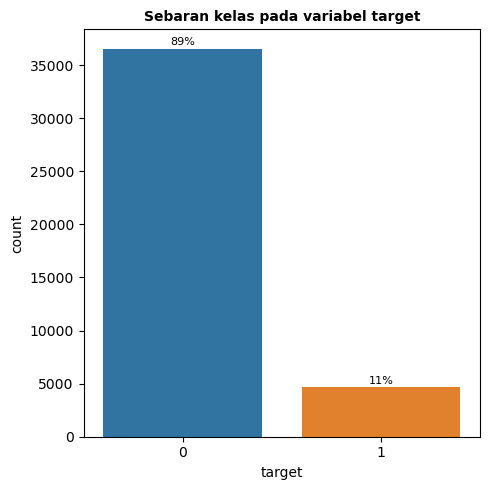

In [10]:
plt.figure(figsize=(5,5))
ax = sns.countplot(data = df, x = 'target', order = df['target'].value_counts().index)

for p in ax.patches:
    ax.annotate(f'{round(100*p.get_height()/len(df))}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
    ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')
    
plt.title(f'Sebaran kelas pada variabel target', fontsize = 10, fontweight = 'bold')
plt.tight_layout()

Berdasarkan visualisasi diatas dapat ditarik kesimpulan bahwa terjadi imbalanced class pada variabel target. Artinya nasabah yang tidak membuka deposito (kelas 0) lebih banyak dibandingkan dengan nasabah yang membuka deposito (kelas 1), dengan selisih proporsi yang cukup besar.

In [11]:
# inisiasi variabel katergorik dan numerik untuk mempermudah saat EDA
kategorik = df.columns[df.dtypes == object]
numerik = df.columns[df.dtypes != object]

## Data Kategorik

In [12]:
# statistika deskriptif data kategorik
df[kategorik].describe(include='object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,41176,41176,41176,41176,41176,41176,41176,41176,41176,41176
unique,12,4,8,3,3,3,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent
freq,10419,24921,12164,32577,21571,33938,26135,13767,8618,35551


In [13]:
# pengecekan data unique pada variabel kategorik
listItem = []
for col in df[kategorik].columns :
    listItem.append( [col, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col]))*100, 3), df[col].nunique(), df.sort_values(col)[col].unique()])

kategorik_unique = pd.DataFrame(columns=['Nama','Jumlah data kosong', 'Persentase data kosong', 'Jumlah Data Unique', 'Data Unique'],
                     data=listItem)
kategorik_unique

,Nama,Jumlah data kosong,Persentase data kosong,Jumlah Data Unique,Data Unique
0,job,0,0.0,12,"[admin., blue-collar, entrepreneur, housemaid, management, retired, self-employed, services, student, technician, unemployed, unknown]"
1,marital,0,0.0,4,"[divorced, married, single, unknown]"
2,education,0,0.0,8,"[basic.4y, basic.6y, basic.9y, high.school, illiterate, professional.course, university.degree, unknown]"
3,default,0,0.0,3,"[no, unknown, yes]"
4,housing,0,0.0,3,"[no, unknown, yes]"
5,loan,0,0.0,3,"[no, unknown, yes]"
6,contact,0,0.0,2,"[cellular, telephone]"
7,month,0,0.0,10,"[apr, aug, dec, jul, jun, mar, may, nov, oct, sep]"
8,day_of_week,0,0.0,5,"[fri, mon, thu, tue, wed]"
9,poutcome,0,0.0,3,"[failure, nonexistent, success]"


- Dapat dilihat pada fitur kategorik tidak terdapat data yang kosong, namun perlu diperhatikan terdapat beberapa fitur yang memiliki data unique unknown. Data unknown bisa disebabkan karena data tersebut memang sebagai missing value, sehingga data tersebut memang tidak ada. Selain dari itu  bisa saja bahwa data tersebut ada, namun kurang baik saat proses dokumentasi. Untuk lebih jelasnya perlu dicari berapa banyak data unknown yang dimiliki setiap fiturnya. Fitur-fitur yang memiliki data unknown adalah `job`, `marital`, `education`, `default`, `housing`, dan `loan`.
- Berbeda dari fitur yang memiliki data unknown, fitur `poutcome` memiliki data unique nonexistent. Artinya data tersebut memang tidak ada, oleh karena itu perlu ditelusuri lebih lanjut.

- fitur `month` hanya terdapat 10 bulan -> mar, apr, may, jun, jul, aug, sep, oct, nov, dec (10 bulan)
- ditur `day_of_week` hanya terdapat 5 hari -> mon, tue, wed, thu, frid (5 hari)


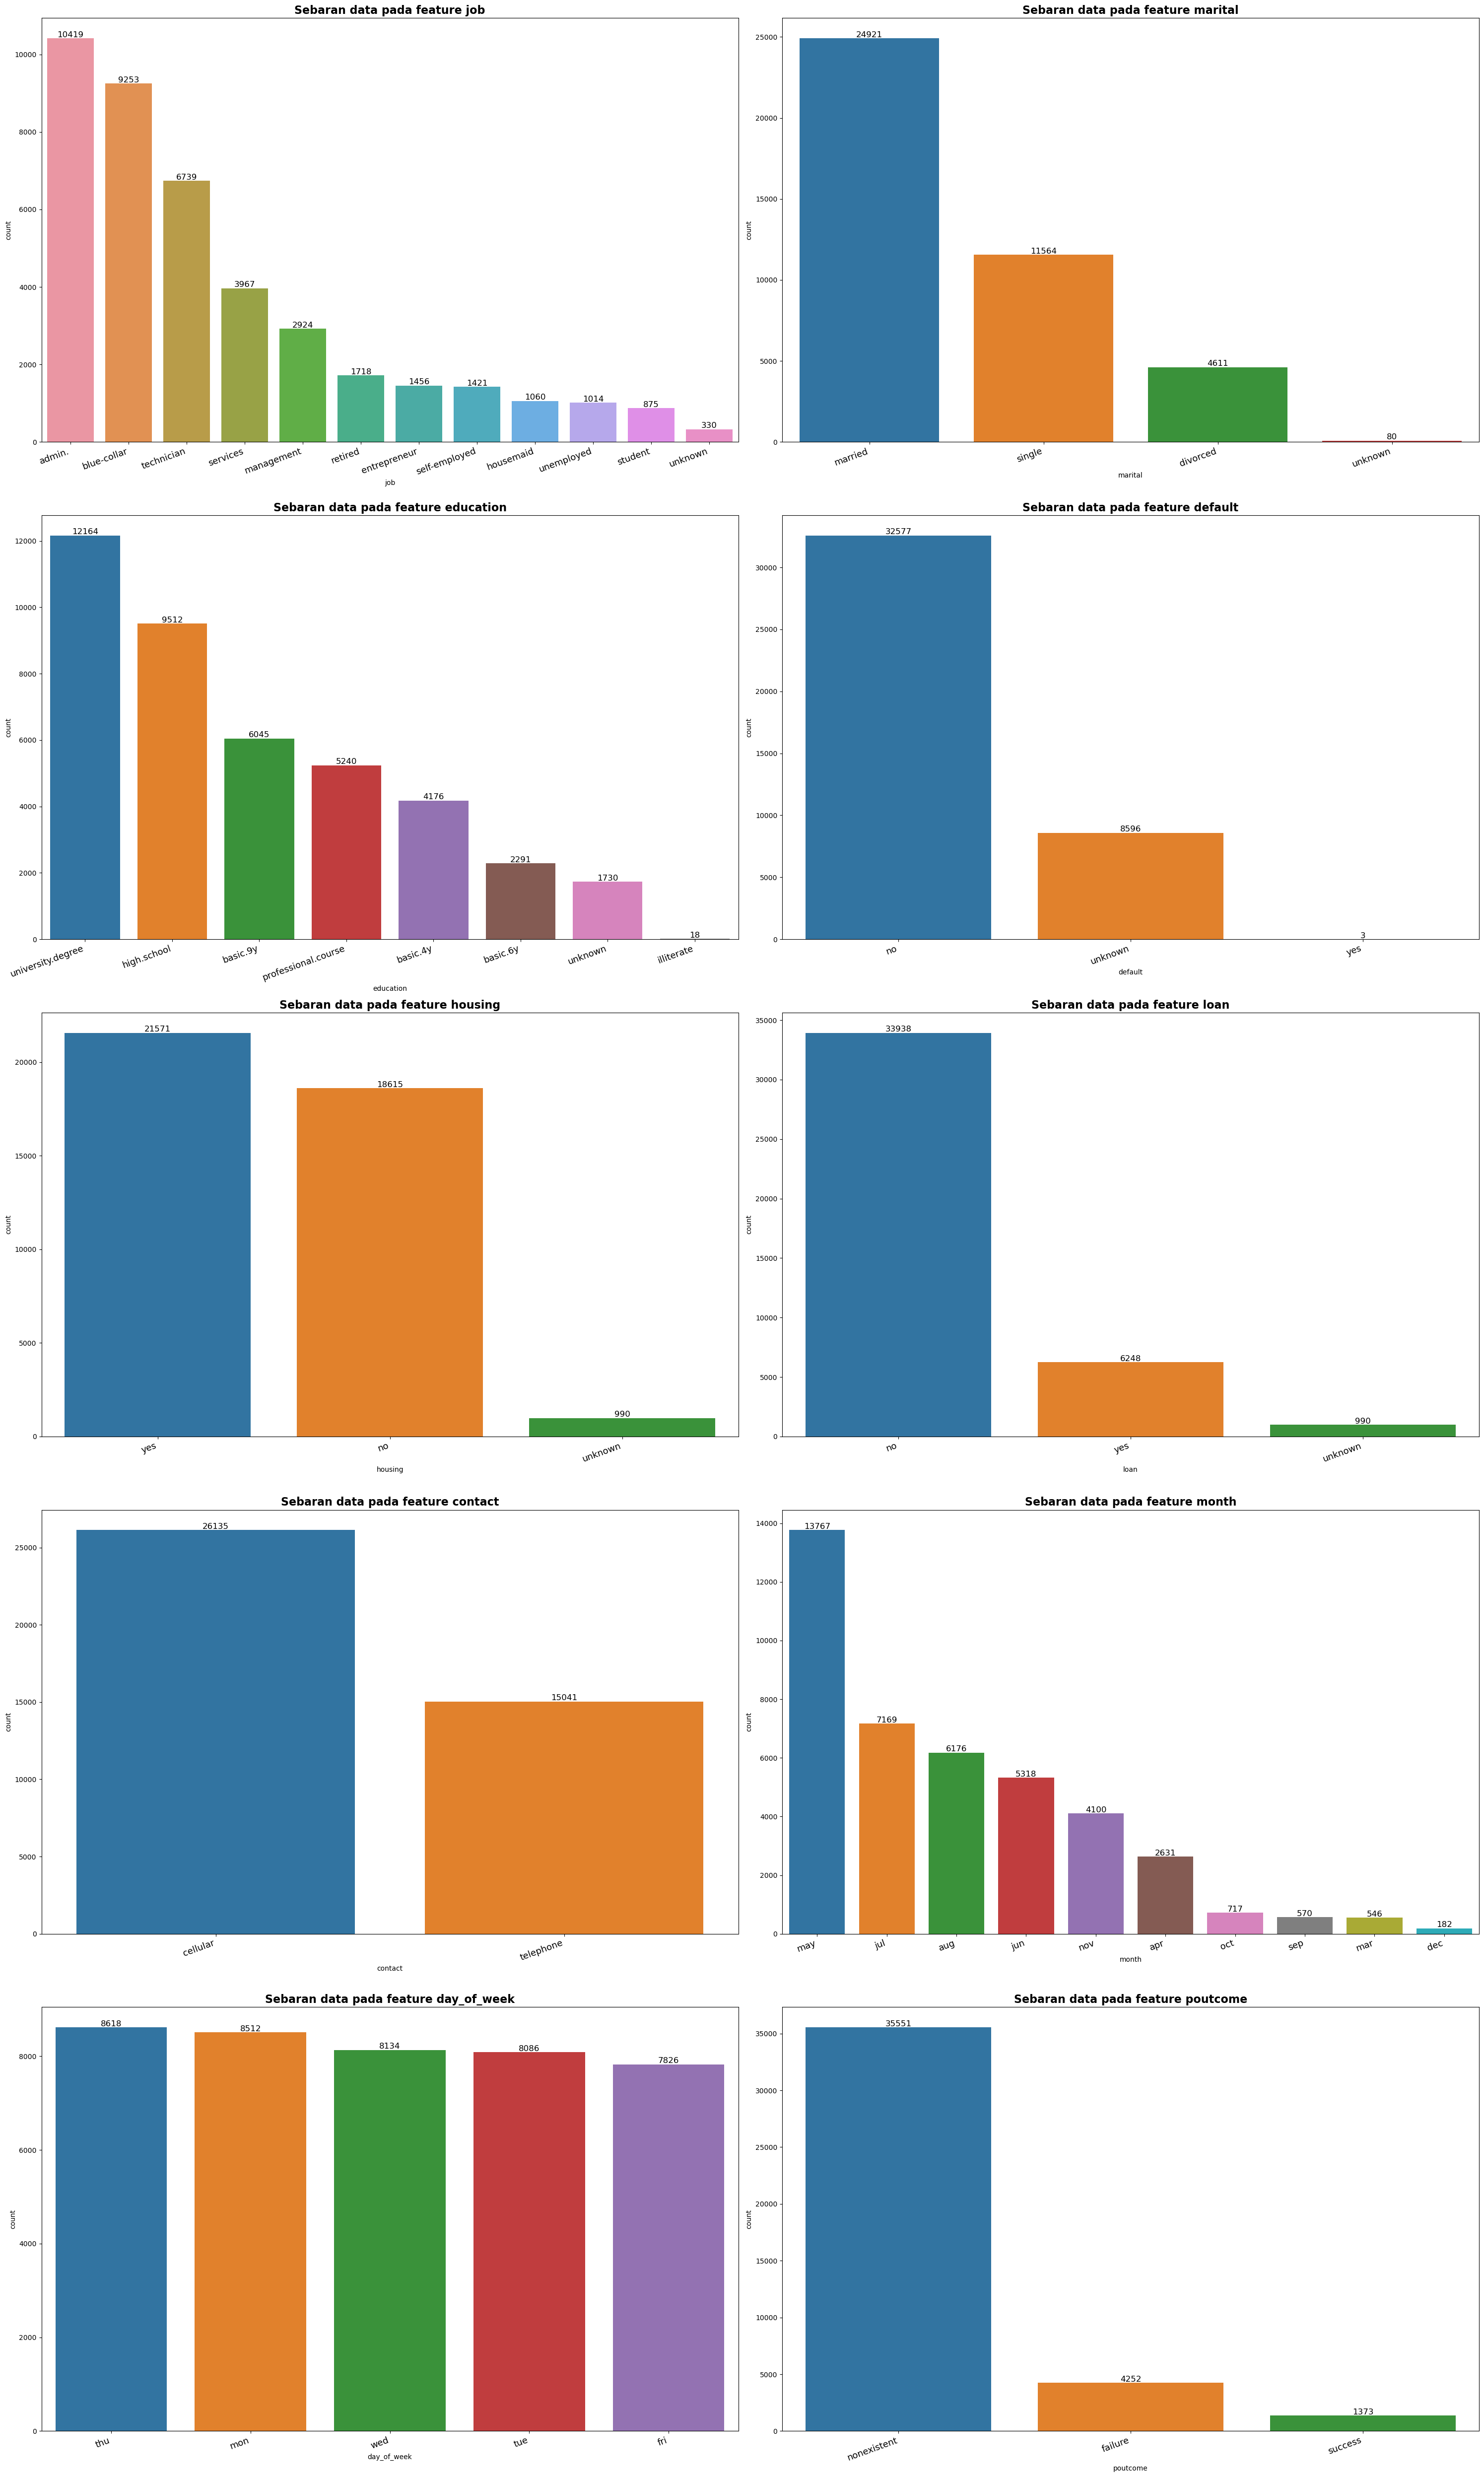

In [14]:
# visualisasi sebaran data setiap data kategorik.

plt.figure(figsize=(30,50))
plot_num = 1

for feature in kategorik:
    plt.subplot(5, 2, plot_num)

    ax = sns.countplot(data = df, x = feature, order = df[feature].value_counts().index)
    for p in ax.patches:
        ax.annotate(f'{round(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),textcoords='offset points')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, fontsize = 13, ha="right")
    
    plt.title(f'Sebaran data pada feature {feature}', fontsize = 16, fontweight = 'bold')
    plt.tight_layout()
    plot_num += 1

Terdapat temuan menarik pada sebaran data fitur `default`. Dapat dilihat bahwa pada fitur `default` hanya memiliki data yes berjumlah 3. Kebanyakan jumlah data pada no serta jumlah unknown data yang relatif besar.

In [15]:
# mengecek jumlah dan persentase data unknown

unknown = ['job', 'marital', 'education', 'default', 'housing', 'loan']

listItem = []
for col in unknown :
    listItem.append([col, len(df[df[col] == 'unknown']), round((len(df[df[col] == 'unknown'])/len(df[col]))*100, 2)])

unknown_data = pd.DataFrame(columns=['Nama','Jumlah unknown data', 'Persentase unknown data'],
                     data=listItem)
unknown_data

,Nama,Jumlah unknown data,Persentase unknown data
0,job,330,0.80
1,marital,80,0.19
2,education,1730,4.20
3,default,8596,20.88
4,housing,990,2.40
5,loan,990,2.40


- Berdasarkan hasil pengecekan unknown data, dapat dilihat mayoritas fitur hanya memiliki persentase unknown data yang relatif kecil, kecuali fitur `default`. Dikarenakan sesuai temuan sebelumnya bahwa fitur `default` hanya memiliki jumlah data yes sebanyak 3 dan memiliki banyak unknown data maka data tersebut tidak akan digunakan atau akan didrop pada tahap data preparation nantinya.
- Terdapat temuan menarik, jumlah data pada fitur `housing` dan `loan` memiliki jumlah unknown data yang sama banyak, sehingga perlu dianalisis lebih lanjut.

In [16]:
# menelusuri fitur housing dan loan karena memiliki unknown data dengan jumlah yang sama

df_cek_unknown_sama = df[(df['housing'] == 'unknown') | (df['loan'] == 'unknown')]
df_cek_unknown_sama2 = df[(df['housing'] == 'unknown') & (df['loan'] == 'unknown')]


display(df_cek_unknown_sama, df_cek_unknown_sama2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,target
29,55,unknown,married,university.degree,unknown,unknown,unknown,telephone,may,mon,362,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
81,51,blue-collar,married,basic.4y,unknown,unknown,unknown,telephone,may,mon,212,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
261,27,blue-collar,single,basic.6y,no,unknown,unknown,telephone,may,mon,119,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
385,59,management,married,basic.4y,unknown,unknown,unknown,telephone,may,tue,437,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
401,48,services,married,high.school,unknown,unknown,unknown,telephone,may,tue,152,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40990,31,admin.,single,university.degree,no,unknown,unknown,cellular,oct,tue,192,1,3,1,success,-1.1,94.601,-49.5,1.008,4963.6,1
41014,31,technician,single,professional.course,no,unknown,unknown,cellular,oct,thu,212,2,999,0,nonexistent,-1.1,94.601,-49.5,1.025,4963.6,1
41015,34,admin.,divorced,university.degree,no,unknown,unknown,cellular,oct,thu,256,2,999,1,failure,-1.1,94.601,-49.5,1.025,4963.6,0
41029,46,management,married,university.degree,no,unknown,unknown,cellular,oct,mon,83,2,12,2,failure,-1.1,94.601,-49.5,1.032,4963.6,0


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,target
29,55,unknown,married,university.degree,unknown,unknown,unknown,telephone,may,mon,362,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
81,51,blue-collar,married,basic.4y,unknown,unknown,unknown,telephone,may,mon,212,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
261,27,blue-collar,single,basic.6y,no,unknown,unknown,telephone,may,mon,119,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
385,59,management,married,basic.4y,unknown,unknown,unknown,telephone,may,tue,437,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
401,48,services,married,high.school,unknown,unknown,unknown,telephone,may,tue,152,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40990,31,admin.,single,university.degree,no,unknown,unknown,cellular,oct,tue,192,1,3,1,success,-1.1,94.601,-49.5,1.008,4963.6,1
41014,31,technician,single,professional.course,no,unknown,unknown,cellular,oct,thu,212,2,999,0,nonexistent,-1.1,94.601,-49.5,1.025,4963.6,1
41015,34,admin.,divorced,university.degree,no,unknown,unknown,cellular,oct,thu,256,2,999,1,failure,-1.1,94.601,-49.5,1.025,4963.6,0
41029,46,management,married,university.degree,no,unknown,unknown,cellular,oct,mon,83,2,12,2,failure,-1.1,94.601,-49.5,1.032,4963.6,0


Ternyata setelah ditelusuri, nasabah yang memilki data unknown pada fitur `loan` memilki data unknown juga pada fitur `housing` yang menyebabkan fitur tersebut memiliki jumlah unknown data yang sama. Hal itu bisa saja teradi karena proses dokumentasi data yang kurang baik, sehingga terdapat data unknown yang saling berhubungan antara fitur `housing` dan `loan`.

In [17]:
cek_unknown_kategorik = df_cek_unknown_sama2.columns[df_cek_unknown_sama2.dtypes == object]
cek_unknown_kategorik

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [18]:
# memeriksa apakah terdapat hubungan nasabah yang memiliki unknown data pada fitur loan dan housing memiliki juga unknown data pada fitur lainnya.

for col in cek_unknown_kategorik.drop(['loan', 'housing','contact', 'month', 'day_of_week']):
    print(f'{col} \n{df_cek_unknown_sama2[col].value_counts()} \n ')

job 
blue-collar      240
admin.           227
technician       147
services         101
management        71
retired           44
self-employed     40
entrepreneur      36
housemaid         29
unemployed        27
student           23
unknown            5
Name: job, dtype: int64 
 
marital 
married     588
single      280
divorced    121
unknown       1
Name: marital, dtype: int64 
 
education 
university.degree      277
high.school            220
basic.9y               151
professional.course    125
basic.4y               117
basic.6y                60
unknown                 40
Name: education, dtype: int64 
 
default 
no         763
unknown    227
Name: default, dtype: int64 
 
poutcome 
nonexistent    851
failure        111
success         28
Name: poutcome, dtype: int64 
 


Berdasarkan hasil penelusuran di atas, dapat dilihat bahwa hanya sedikit nasabah yang memiliki unknown data pada fitur `loan` dan `housing`, kemudian memiliki juga unknown data pada fitur lainnnya.

Setelah data unknown diperiksa selanjutnya memeriksa data nonexistent pada fitur `poutcome`

In [19]:
df['poutcome'].value_counts()

nonexistent    35551
failure         4252
success         1373
Name: poutcome, dtype: int64

In [20]:
df_cek_nonexistent = df[df['poutcome'] == 'nonexistent']
df_cek_nonexistent

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,target
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41181,37,admin.,married,university.degree,no,yes,no,cellular,nov,fri,281,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0


In [21]:
df_cek_nonexistent['previous'].value_counts()

0    35551
Name: previous, dtype: int64

fitur `poutcome` menjelaskan hasil nasabah dari campaign marketing terdahulu. Oleh karena itu dapat diartikan bahwa nasabah yang memiliki data nonexistent pada fitur `poutcome` tidak mendapatkan campaign marketing terdahulu, sehingga tidak ada datanya. Hal tersebut berati hal yang wajar atau bisa dikatakan data tersebut valid.

## Data Numerik

In [22]:
# statistika deskriptif data numerik
df[numerik].describe()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,target
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870,0.112663
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364,0.316184
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [23]:
# pengecekan data unique pada variabel numerik
listItem = []
for col in df[numerik].columns :
    listItem.append( [col, df[col].nunique(), df.sort_values(col)[col].unique()])

numerik_unique = pd.DataFrame(columns=['Nama', 'Jumlah Data Unique', 'Data Unique'],
                     data=listItem)
numerik_unique

,Nama,Jumlah Data Unique,Data Unique
0,age,78,"[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 94, 95, 98]"
1,duration,1544,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]"
2,campaign,42,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 39, 40, 41, 42, 43, 56]"
3,pdays,27,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 999]"
4,previous,8,"[0, 1, 2, 3, 4, 5, 6, 7]"
5,emp_var_rate,10,"[-3.4, -3.0, -2.9, -1.8, -1.7, -1.1, -0.2, -0.1, 1.1, 1.4]"
6,cons_price_idx,26,"[92.201, 92.379, 92.431, 92.469, 92.649, 92.713, 92.756, 92.843, 92.893, 92.963, 93.075, 93.2, 93.369, 93.444, 93.749, 93.798, 93.876, 93.918, 93.994, 94.027, 94.055, 94.199, 94.215, 94.465, 94.601, 94.767]"
7,cons_conf_idx,26,"[-50.8, -50.0, -49.5, -47.1, -46.2, -45.9, -42.7, -42.0, -41.8, -40.8, -40.4, -40.3, -40.0, -39.8, -38.3, -37.5, -36.4, -36.1, -34.8, -34.6, -33.6, -33.0, -31.4, -30.1, -29.8, -26.9]"
8,euribor3m,316,"[0.634, 0.635, 0.636, 0.637, 0.638, 0.639, 0.64, 0.642, 0.643, 0.644, 0.645, 0.646, 0.649, 0.65, 0.651, 0.652, 0.653, 0.654, 0.655, 0.659, 0.663, 0.668, 0.672, 0.677, 0.682, 0.683, 0.684, 0.685, 0.688, 0.69, 0.692, 0.695, 0.697, 0.699, 0.7, 0.701, 0.702, 0.704, 0.706, 0.707, 0.708, 0.709, 0.71, 0.711, 0.712, 0.713, 0.714, 0.715, 0.716, 0.717, 0.718, 0.719, 0.72, 0.721, 0.722, 0.723, 0.724, 0.727, 0.728, 0.729, 0.73, 0.731, 0.732, 0.733, 0.735, 0.737, 0.739, 0.74, 0.741, 0.742, 0.743, 0.744, 0.748, 0.749, 0.75, 0.752, 0.753, 0.754, 0.755, 0.761, 0.762, 0.766, 0.767, 0.768, 0.77, 0.771, 0.773, 0.778, 0.781, 0.782, 0.788, 0.79, 0.793, 0.797, 0.802, 0.803, 0.809, 0.81, 0.813, 0.819, ...]"
9,nr_employed,11,"[4963.6, 4991.6, 5008.7, 5017.5, 5023.5, 5076.2, 5099.1, 5176.3, 5191.0, 5195.8, 5228.1]"


Terdapat data pada fitur `pdays` yang perlu diperhatikan. Data yang perlu diperhatikan adalah data dengan nilai **999**. Hal tersebut menunjukan bahwa nasabah yang memiliki data tersebut tidak dikontak campaign terdahulu.

### Distribusi Data

In [24]:
rekap = pd.DataFrame()
kolom = []
pval = []
hasil = []
angka = 0


for i in df[numerik].columns.drop('target'):
    
    angka += 1
    kolom.append(i)

    dp_statistic, dp_pvalue = normaltest(df[i])

    if dp_pvalue > 0.05 :
        a = 'So, we assume a normal distribution'
        pval.append(dp_pvalue)
        hasil.append(a)
    else :
        b = 'So, we dont assume a normal distribution'
        pval.append(dp_pvalue)
        hasil.append(b)

    if angka == len(df[numerik].columns.drop('target')):
        rekap['Kolom'] = kolom
        rekap['Pval'] = pval
        rekap['Hasil'] = hasil

rekap   

,Kolom,Pval,Hasil
0,age,0.000000e+00,"So, we dont assume a normal distribution"
1,duration,0.000000e+00,"So, we dont assume a normal distribution"
2,campaign,0.000000e+00,"So, we dont assume a normal distribution"
3,pdays,0.000000e+00,"So, we dont assume a normal distribution"
4,previous,0.000000e+00,"So, we dont assume a normal distribution"
5,emp_var_rate,0.000000e+00,"So, we dont assume a normal distribution"
6,cons_price_idx,0.000000e+00,"So, we dont assume a normal distribution"
7,cons_conf_idx,5.147000e-204,"So, we dont assume a normal distribution"
8,euribor3m,0.000000e+00,"So, we dont assume a normal distribution"
9,nr_employed,0.000000e+00,"So, we dont assume a normal distribution"


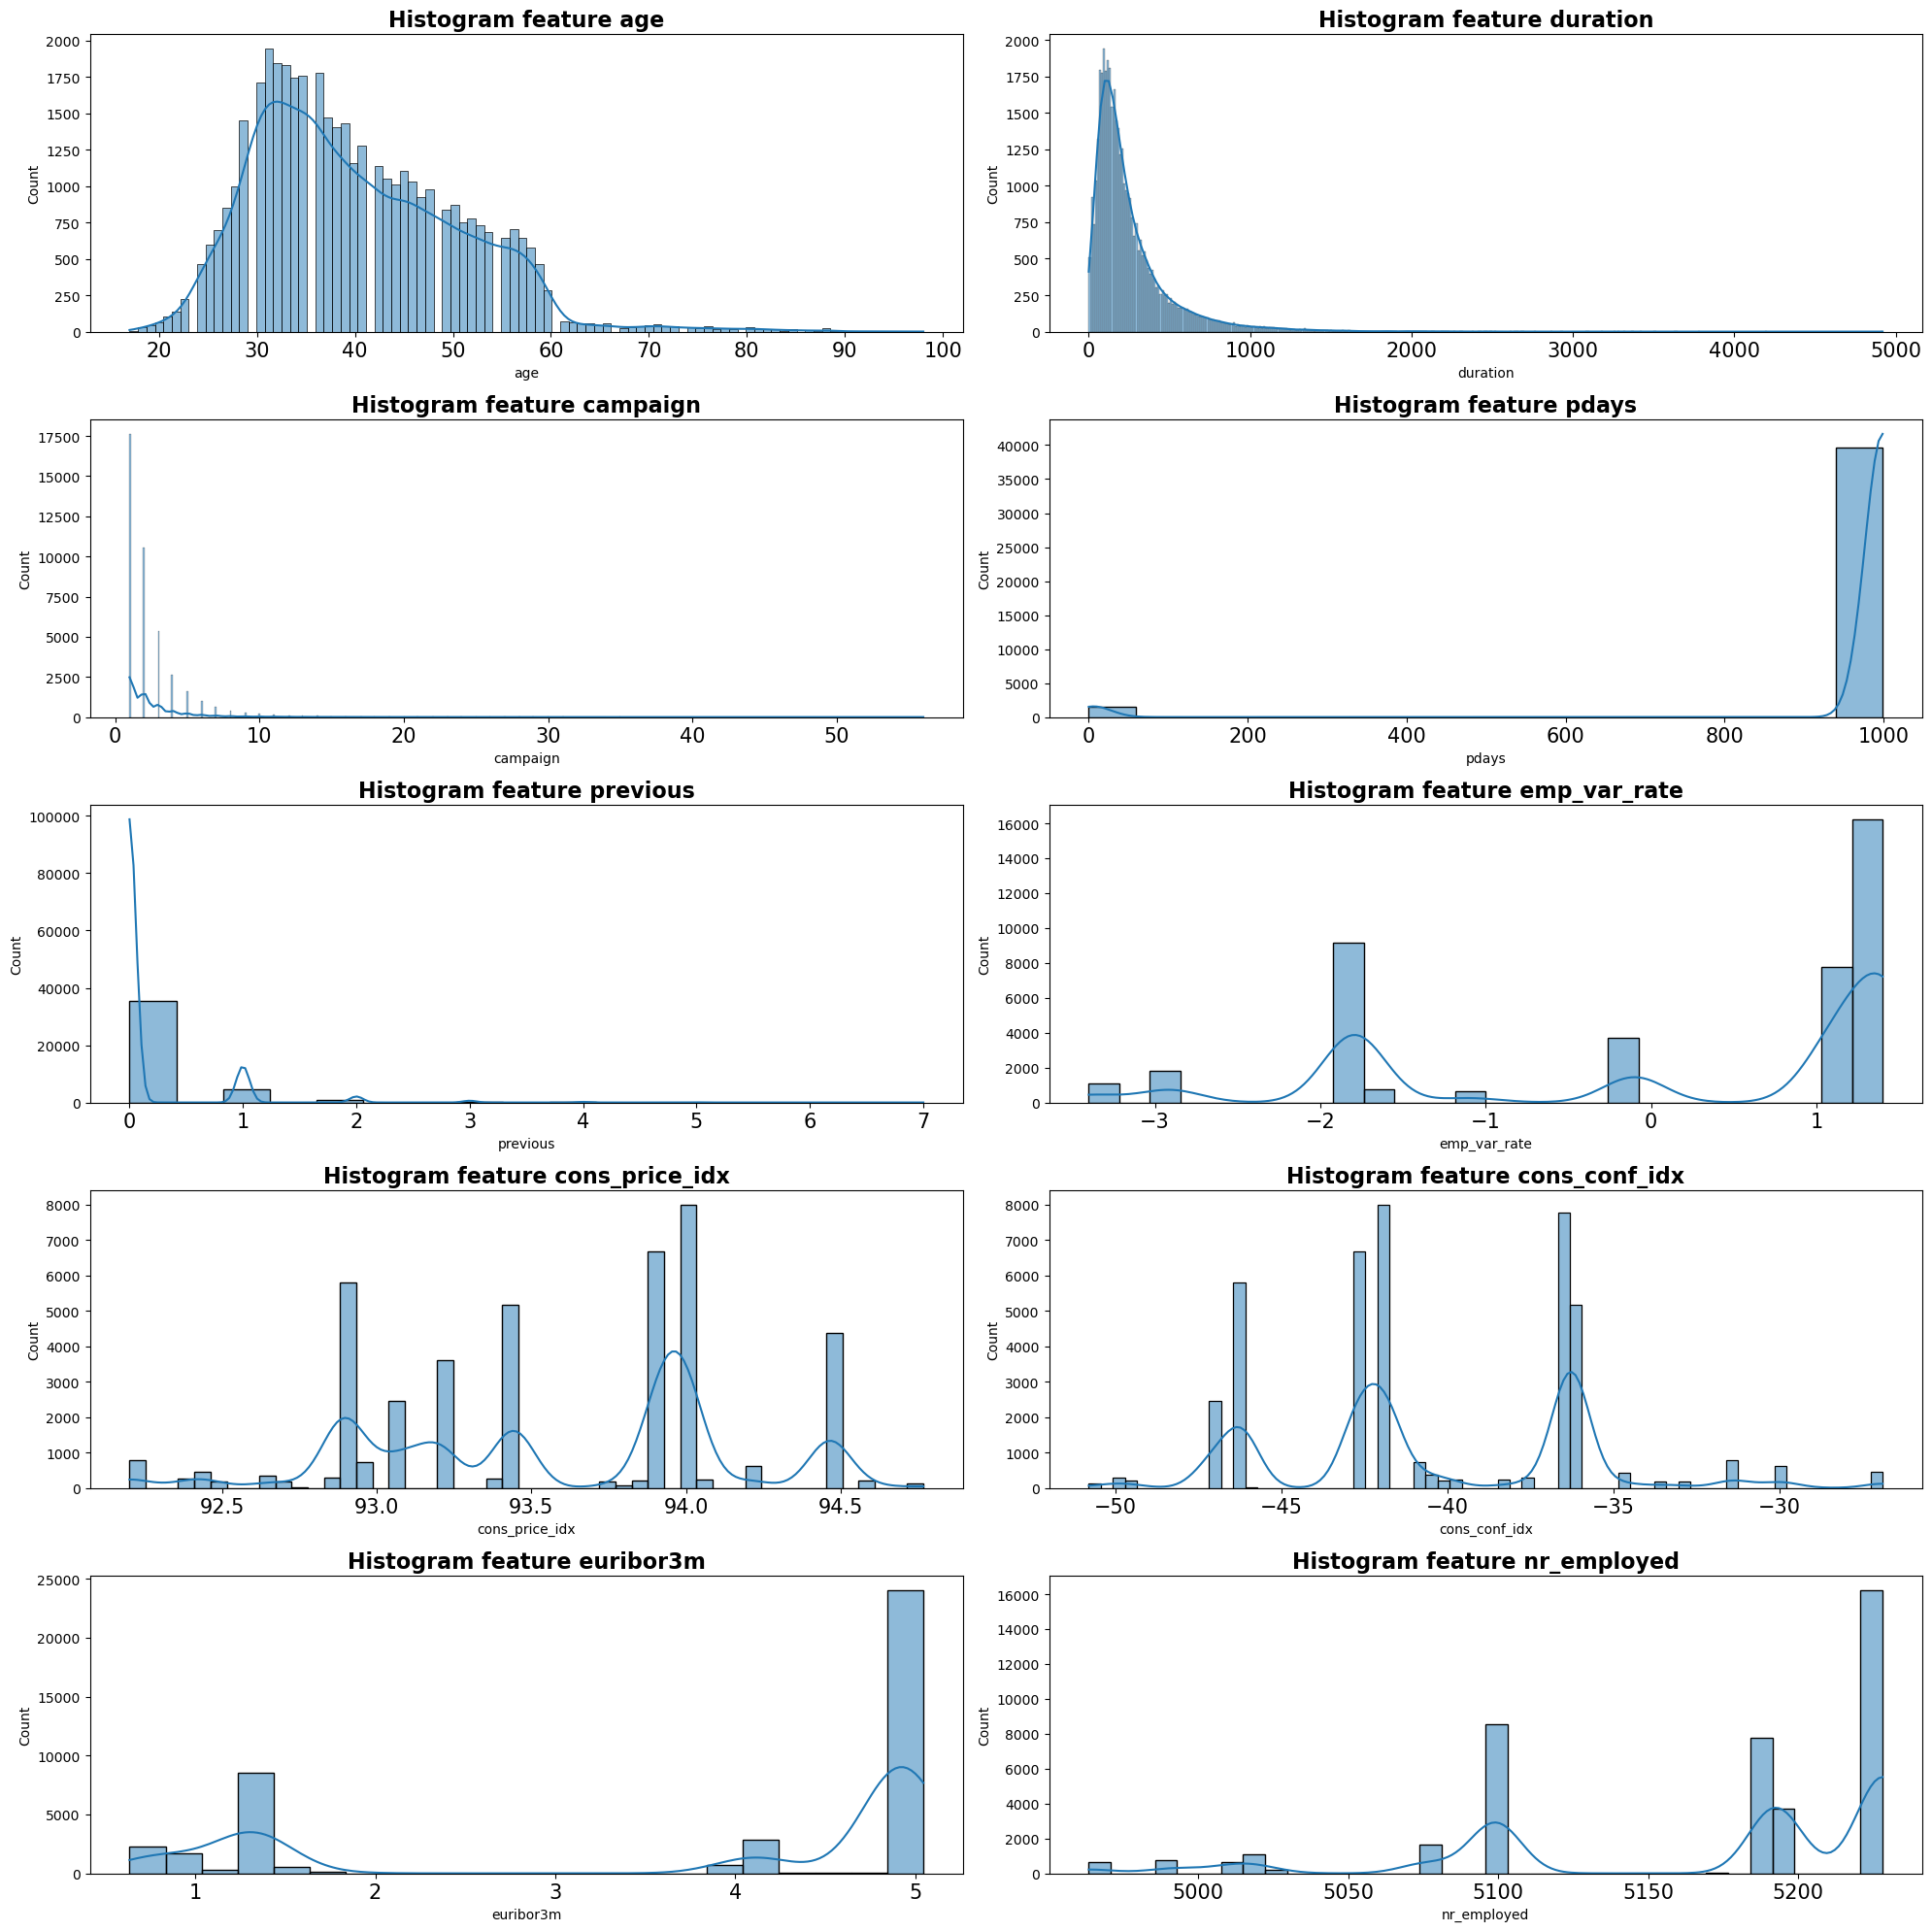

In [25]:
# visualisasi histogram data setiap data numerik
plt.figure(figsize=(20,20))
plot_num = 1

for feature in numerik.drop('target'):
    plt.subplot(5, 2, plot_num)
    ax = sns.histplot(data = df, x = feature, kde=True)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15)
    plt.title(f'Histogram feature {feature}', fontsize = 16, fontweight = 'bold')
    plt.tight_layout()
    plot_num += 1

- Dari hasil normaltest serta visualisasi sebaran data fitur numerik, dapat dilihat bahwa seluruh fitur numerik tidak berdistribusi normal
- Sebaran data fitur `age` dan `duration` membentuk right skewed distribution. Hal tersebut dapat menandakan bahwa pada fitur tersebut memiliki outlier yang bernilai besar. 
- Sesuai paparan sebelumnya data 999 pada fitur `pdays` menunjukan bahwa nasabah tersebut tidak dikontak campaign sebelumnya. Hal itu menyebabkan sebaran data fitur `pdays` memiliki rentang yang besar, selain itu memiliki selisih frekuensi yang sangat besar. Oleh karena itu baiknya merubah fitur `pdays` yang sebelumnya continous variabel menjadi categorical variabel, berdasarkan deskripsi bahwa data 999 menunjukan nasabah tersebut tidak dikontak pada campaign terdahulu. 

In [26]:
# mencoba melihat fitur pdays yang memiliki data 999

df_cek_pdays = df[df['pdays'] == 999]
df_cek_pdays

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,target
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


fitur `pday` memiliki hubungan dengan fitur `poutcome` serta `previous`, hal tersebut dapat dilihat berdasarkan deskripsi fitur tarsebut pada bagian awal. Singkatnya ke-3 fitur tersebut menggambarkan mengenai campaign terdahulu. Oleh karena itu untuk menganalisis akan dilihat berdasarkan fitur tersebut.

In [27]:
df_cek_pdays['previous'].value_counts()

0    35551
1     3696
2      349
3       50
4       12
5        2
6        1
Name: previous, dtype: int64

In [28]:
df_cek_pdays['poutcome'].value_counts()

nonexistent    35551
failure         4110
Name: poutcome, dtype: int64

- fitur `pdays` menunjukan selisih hari nasabah dikontak campaign terdahulu dengan campaign terkinini
- fitur `previous` menunjukan jumlah berapa kali nasabah dikontak pada campaign terdahulu
- fitur `poutcome` menunjukan hasil campaign terdahulu

Terdapat nasabah yang memiliki data pada fitur `pdays` 999, namun berdasarkan fitur `previous` nasabah tersebut telah dikontak, selain itu berdasarkan fitur `poutcome` terdapat hasil campaign terdahulu untuk nasabah tersebut. Berdasarkan hal tersebut dapat dikatakan bahwa data tersebut tidak valid, karena data antar fitur saling berlawanan.

In [29]:
df_ga_valid = df_cek_pdays[(df_cek_pdays['previous'] > 0) & (df_cek_pdays['poutcome'] == 'failure')]
display(len(df_ga_valid), df_ga_valid)

4110

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,target
24013,38,blue-collar,single,unknown,no,yes,no,telephone,oct,tue,39,1,999,1,failure,-0.1,93.798,-40.4,4.968,5195.8,0
24019,40,services,married,high.school,no,yes,no,telephone,oct,tue,144,1,999,1,failure,-0.1,93.798,-40.4,4.968,5195.8,1
24076,36,admin.,married,university.degree,no,yes,no,telephone,nov,wed,449,1,999,1,failure,-0.1,93.200,-42.0,4.663,5195.8,0
24102,36,admin.,married,high.school,no,yes,no,telephone,nov,wed,114,1,999,1,failure,-0.1,93.200,-42.0,4.286,5195.8,1
24113,29,self-employed,married,university.degree,no,yes,no,telephone,nov,thu,86,1,999,1,failure,-0.1,93.200,-42.0,4.245,5195.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41166,32,admin.,married,university.degree,no,no,no,telephone,nov,wed,651,1,999,1,failure,-1.1,94.767,-50.8,1.030,4963.6,1
41170,40,management,divorced,university.degree,no,yes,no,cellular,nov,wed,293,2,999,4,failure,-1.1,94.767,-50.8,1.030,4963.6,0
41173,62,retired,married,university.degree,no,yes,no,cellular,nov,thu,329,1,999,2,failure,-1.1,94.767,-50.8,1.031,4963.6,1
41175,34,student,single,unknown,no,yes,no,cellular,nov,thu,180,1,999,2,failure,-1.1,94.767,-50.8,1.031,4963.6,0


### Outlier

In [30]:
cek_outlier(df, numerik.drop('target'))[0]

,Kolom,Q1,Q3,IQR,Batas Atas,Batas Bawah,Jumlah Outlier,Proporsi(%)
4,previous,0.000,0.000,0.000,0.0000,0.0000,5625,13.660870
1,duration,102.000,319.000,217.000,644.5000,-223.5000,2963,7.195939
2,campaign,1.000,3.000,2.000,6.0000,-2.0000,2406,5.843210
3,pdays,999.000,999.000,0.000,999.0000,999.0000,1515,3.679328
0,age,32.000,47.000,15.000,69.5000,9.5000,468,1.136584
7,cons_conf_idx,-42.700,-36.400,6.300,-26.9500,-52.1500,446,1.083155
5,emp_var_rate,-1.800,1.400,3.200,6.2000,-6.6000,0,0.000000
6,cons_price_idx,93.075,93.994,0.919,95.3725,91.6965,0,0.000000
8,euribor3m,1.344,4.961,3.617,10.3865,-4.0815,0,0.000000
9,nr_employed,5099.100,5228.100,129.000,5421.6000,4905.6000,0,0.000000


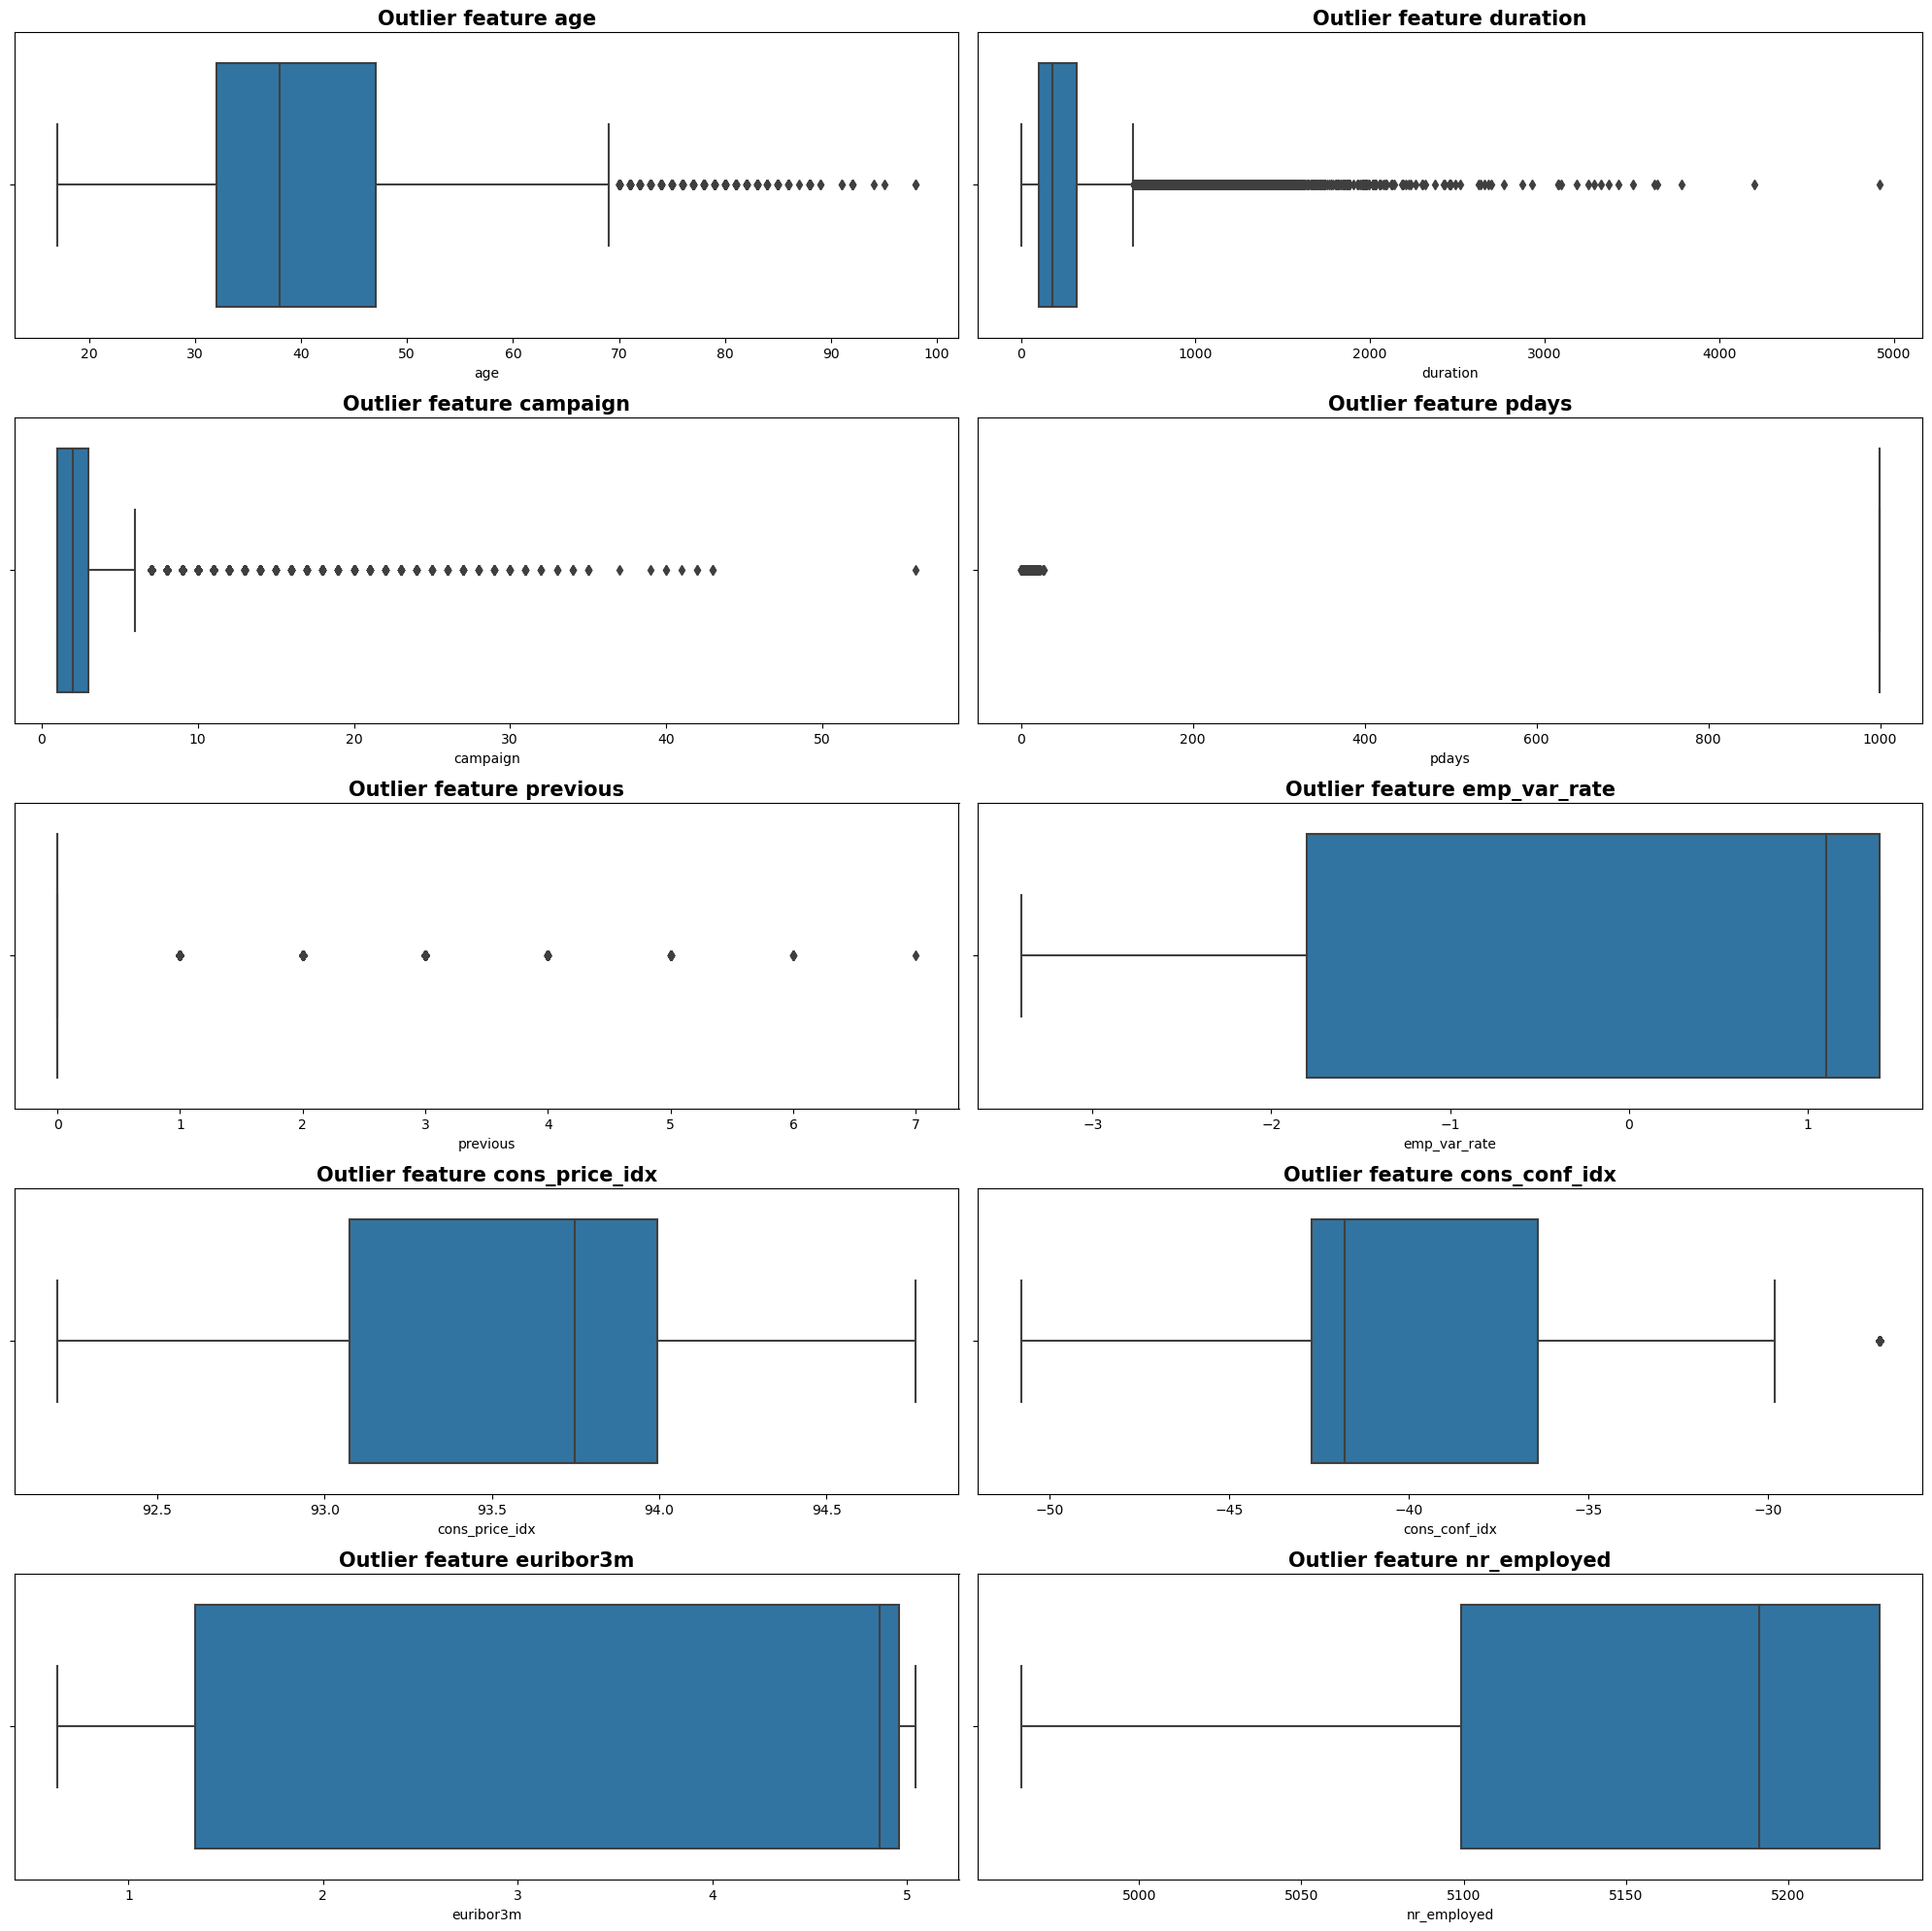

In [31]:
# visualisasi outlier dengan boxplot

plt.figure(figsize=(20,20))
plot_num = 1

for feature in numerik.drop('target'):
    plt.subplot(5, 2, plot_num)
    sns.boxplot(data = df, x = feature)
    plt.title(f'Outlier feature {feature}', fontsize = 15, fontweight = 'bold')
    plt.tight_layout()
    plot_num += 1

## Korelasi

### - Korelasi fitur numerik dengan target

In [32]:
round(df.corr(method='spearman')['target'], 3)

age              -0.012
duration          0.349
campaign         -0.064
pdays            -0.325
previous          0.201
emp_var_rate     -0.247
cons_price_idx   -0.122
cons_conf_idx     0.041
euribor3m        -0.267
nr_employed      -0.284
target            1.000
Name: target, dtype: float64

Koefisien korelasi:
- 0 - 0.3 -> week
- 0.3 - 0.7 -> medium
- 0.7 - 1 -> strong

Berdasarkan pengecekan korelasi di atas, dapat dilihat bahwa mayoritas fitur numerik memiliki korelasi yang lemah dengan target, hanya fitur `pdays` dan `duration` yang memiliki korelasi yang medium karena nilainya > 0.3, namun sesuai paparan sebelumnya fitur `pdays` akan dirubah menjadi categorical variabel karena data 999, dan fitur `duration` tidak akan digunakan.

### - Korelasi antar fitur numerik

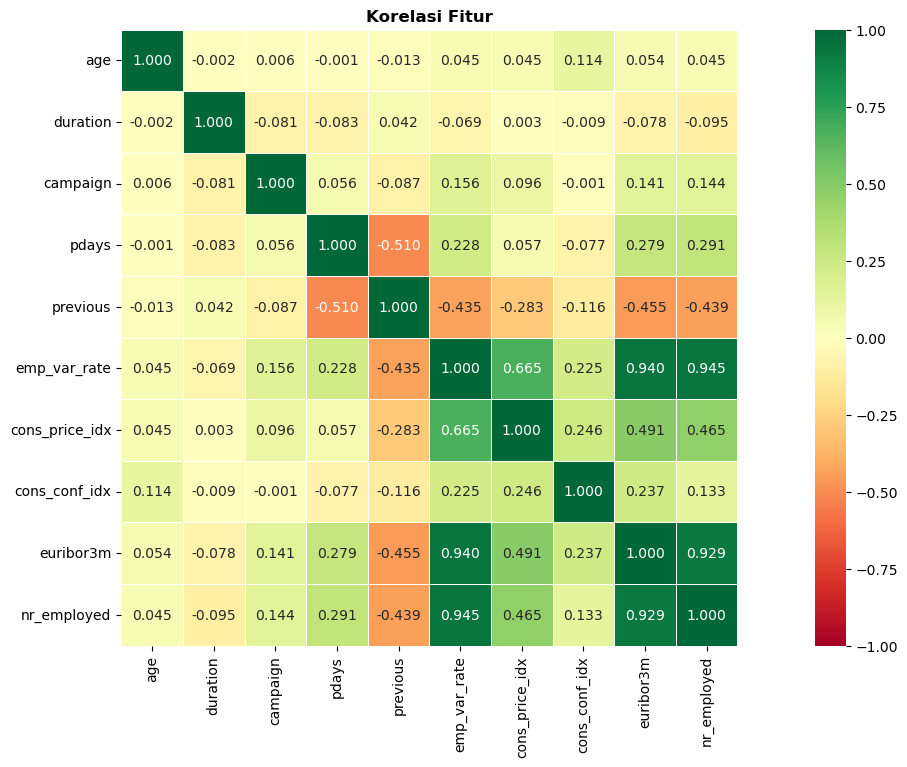

In [33]:
plt.figure(figsize=(20,8))
sns.heatmap(df.drop('target', axis=1).corr(method='spearman'), fmt='.3f', cmap='RdYlGn', annot=True, square=True, vmin=-1, linewidth=.5)
plt.title('Korelasi Fitur', size = 12, weight = 'bold')
plt.show()

Pengecekan korelasi antar fitur dilakukan untuk melihat apakah terjadi multikolinearitas. Multikolinearitas terjadi saat ada korelasi yang kuat antar fitur [(Sushmitha, 2020)](https://towardsdatascience.com/how-to-detect-and-deal-with-multicollinearity-9e02b18695f1). Koefisien korelasi > 0.7 dapat menandakan bahwa terjadi multikolinearitas [(Rekha, 2019)](https://blog.clairvoyantsoft.com/correlation-and-collinearity-how-they-can-make-or-break-a-model-9135fbe6936a). Berdasarkan pemaparan tersebut dapat dilihat bahwa terdapat masalah multikolinearitas antara fitur:
- `euribor3m` dan `emp_var_rate`
- `eruribor3m` dan `nr_employed`

Berdarkan deskripsi fitur yang sudah dipaparkan di bagian awal serta domain knowledge, hal tersebut wajar, karena ke 3 fitur tersebut merupakan fitur yang menggambarkan indeks ekonomi dan sosial, sehingga wajar saja saling mempengaruhi.

Selain dengan koefisien korelasi, multikolinearitas dapat dilihat dari nilai VIF, dimana nilai VIF > 10 menandakan adanya masalah multikolinearitas yang serius.

In [34]:
cek_vif = df[numerik].drop('target', axis=1)
vif(cek_vif).sort_values('vif', ascending=False)

,variabel,vif
9,nr_employed,26743.400836
6,cons_price_idx,22558.159811
8,euribor3m,226.220791
7,cons_conf_idx,120.096263
3,pdays,44.400563
5,emp_var_rate,28.906692
0,age,16.047407
1,duration,2.011088
4,previous,2.001611
2,campaign,1.921537


Berdasarkan pengecekan diatas dapat dilihat bahwa terdapat fitur yang memiliki nilai VIF sangat besar, fitur tersebut adalah `nr_employed` dan `cons_price_idx`, maka dari itu kita akan coba mendrop fitur `nr_employed` terlebih dahulu karena memiliki nilai VIF yang paling besar kemudian kita coba cek nilai VIF kembali.

In [35]:
vif(cek_vif.drop(['nr_employed'], axis = 1)).sort_values('vif', ascending=False)

,variabel,vif
6,cons_price_idx,300.999189
8,euribor3m,118.939347
7,cons_conf_idx,100.914289
3,pdays,43.644109
5,emp_var_rate,19.945751
0,age,16.046778
1,duration,2.009051
4,previous,1.989064
2,campaign,1.919349


Pengecekan VIF kembali dilakukan, masih banyak fitur yang memiliki nilai VIF > 10, maka dari itu akan didrop kembali fitur yang memiliki nilai terbesar dan melakukan penghitungan VIF kembali. Hal tersebut akan dicoba berulang sampai fitur memiliki nilai VIF yang rendah.

In [36]:
vif(cek_vif.drop(['nr_employed', 'cons_price_idx'], axis = 1)).sort_values('vif', ascending=False)

,variabel,vif
7,euribor3m,54.220326
6,cons_conf_idx,44.856260
3,pdays,41.727219
0,age,14.744323
5,emp_var_rate,10.728783
1,duration,1.993427
2,campaign,1.911334
4,previous,1.799826


In [37]:
vif(cek_vif.drop(['nr_employed', 'cons_price_idx', 'euribor3m'], axis = 1)).sort_values('vif', ascending=False)

,variabel,vif
6,cons_conf_idx,39.329506
3,pdays,34.251252
0,age,13.026069
1,duration,1.984829
2,campaign,1.911131
4,previous,1.773761
5,emp_var_rate,1.270346


In [38]:
vif(cek_vif.drop(['nr_employed', 'cons_price_idx', 'euribor3m', 'cons_conf_idx'], axis = 1)).sort_values('vif', ascending=False)

,variabel,vif
3,pdays,11.827812
0,age,11.807276
1,duration,1.949317
2,campaign,1.882852
4,previous,1.463095
5,emp_var_rate,1.240277


In [39]:
vif(cek_vif.drop(['nr_employed', 'cons_price_idx', 'euribor3m', 'cons_conf_idx', 'pdays'], axis = 1)).sort_values('vif', ascending=False)

,variabel,vif
0,age,2.806788
1,duration,1.876380
2,campaign,1.807360
3,previous,1.357316
4,emp_var_rate,1.239101


Saat kita mencoba drop fitur `nr_employed`, `cons_price_idx`, `euribor3m` , `cons_conf_idx` dan `pdays`, nilai VIF fitur sisanya sudah rendah. Hal tersebut menandakan sudah tidak ada masalah multikolinearitas yang serius.

### - Hubungan fitur kategorik dengan target

Untuk melihat hubungan atau keterkaitan antara fitur kategorik dengan target dapat dilihat dengan mencoba uji chi squared test
<br>
H0 = target dan fitur kategorik independen
<br>
H1 = target dan fitur kategorik dependen

In [40]:
hasil_chi = []

for col in kategorik:
    df_cross = pd.crosstab(df[col], df['target'])
    stat, pvalue, dof, expected = chi2_contingency(df_cross)
    hasil_chi.append(round(pvalue,2))

rekap_chi = pd.DataFrame({'Fitur kategorik': kategorik, 'pvalue' : hasil_chi})
rekap_chi['hasil'] = np.where(rekap_chi['pvalue'] > 0.05, 'independen', 'dependen')

rekap_chi

,Fitur kategorik,pvalue,hasil
0,job,0.00,dependen
1,marital,0.00,dependen
2,education,0.00,dependen
3,default,0.00,dependen
4,housing,0.06,independen
5,loan,0.58,independen
6,contact,0.00,dependen
7,month,0.00,dependen
8,day_of_week,0.00,dependen
9,poutcome,0.00,dependen


Berdasarkan hasil chi squared test, dapat dilihat bahwa fitur `housing` dan `loan` memiliki pvalue > 0.05 menandakan bahwa menerima H0, berarti target independen dengan fitur tersebut. Oleh karena itu pada saat melakukan pemodelan fitur tersebut perlu didrop.

**Rekap EDA** 

1. Variabel target
    - variabel target mengalamai imbalanced class, dimana nasabah yang membuka deposito lebih sedikit dibandingkan dengan nasabah yang tidak membuka deposito.
1. Data kategorik
    - terdapat temuan data unknown pada fitur `job`, `marital`, `education`, `default`, `housing` dan `loan`. 
    - terdapat data nonexistent pada fitur `poutcome` artinya data tersebut memang tidak ada.
    - fitur `default` hanya memiliki data yes berjumlah 3. 
    - persentase data unknown kecil, kecuali pada fitur `default`. Data unknown pada fitur `loan` dan `housing` memiliki jumlah yang sama banyak.
    - jumlah data unknown pada fitur `loan` dan `housing` yang sama banyak disebabkan karena nasabah yang memiliki data unkown pada fitur `loan` memiliki data unknown juga pada fitur `housing`.
    - fitur `poutcome` menjelaskan hasil dari campaign marketing terdahulu. Oleh karena itu dapat diartikan bahwa nasabah yang memiliki data nonexistent pada fitur `poutcome` tidak mendapatkan campaign marketing terdahulu, sehingga tidak ada datanya. Hal tersebut berati hal yang wajar atau bisa dikatakan data tersebut valid.
1. Data numerik
    - Terdapat data yang perlu diperhatikan pada fitur `pdays`, yaitu data dengan nilai 999. Nilai tersebut menandakan bahwa nasabah yang memiliki data tersebut tidak dikontak campaign terdahulu
    - Fitur numerik tidak ada yang berdistribusi normal
    - Distrbusi fitur `age` dan `duration` membentuk right skewed distribution, hal tersebut menandakan terdapat outlier yang bernilai besar
    - data 999 pada fitur `pdays` menyebabkan distribusi fitur tersebut memiliki rentang nilai yang sangat besar, serta memiliki selisih frekuensi yang besar. Oleh karena itu fitur tersebut akan diubah menjadi variabel kategorik berdasarkan deskripsi bahwa data 999 menunjukan nasabah tersebut tidak dikontak pada campaign terdahulu.
    - setelah ditelusuri terdapat data yang berlawanan antara fitur `pdays` data 999 dengan fitur `previous` dan `poutrcome`. Dimana terdapat nasabah yang memiliki data 999 pada fitur `pdays` namun berdasarkan fitur `previous` nasabah tersebut telah dikontak serta terdapat hasil campaign terdahulu pada fitur `poutcome`, sehingga data tersebut dianggap tidak valid. Jumlah data tersebut ada 4110.
    - fitur `previous`, `duration`, `campaign`, `pdays`, `age`, dan `cons_conf_idx` memiliki outlier yang relatif sedikit karena masih dibawah 15%.
    - mayoritas fitur numerik memiliki korelasi yang lemah dengan target, hanya fitur `pdays` dan `duration` yang memiliki korelasi medium.
    - berdasarkan koefisien korelasi antar fitur numerik, fitur `euribor3m`, `emp_var_rate` dan `nr_employed` mengalami masalah multikolinearitas.
    - berdasarkan nilai VIF fitur `nr_employed`, `cons_price_idx`, `euribor3m` , `cons_conf_idx` dan `pdays` perlu didrop  saat pemodelan untuk menghindari masalah multikolinearitas yang serius.
    - berdasarkan hasil chi squared test, variabel target independen dengan fitur `housing` dan `load` sehingga perlu didrop saat pemodelan.

# Data Preparation for Modeling

In [41]:
# membuat variabel baru dari hasil copy variabel df, untuk menjadi variabel yang disiapkan
df_prep = df.copy()
df_prep.drop(['default', 'duration'], axis= 1, inplace=True)
df_prep

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,target
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,professional.course,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,university.degree,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,technician,married,professional.course,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


## Data Cleaning

Memfilter data yang pada fitur `pdays` bernilai 999, namun masih memiliki data pada fitur `poutcome` dan `previous` yang menyatakan bahwa nasabah tersebut pernah dihubungi pada campaign sebelumnya. Setelah difilter, data tersebut akan dibuang, karena tidak valid.

In [42]:
len(df_prep[(df_prep['pdays'] == 999) & (df_prep['poutcome'] == 'failure') & (df_prep['previous'] > 0)].index)

4110

In [43]:
index = df_prep[(df_prep['pdays'] == 999) & (df_prep['poutcome'] == 'failure') & (df_prep['previous'] > 0)].index
df_prep.drop(index, axis=0, inplace=True)
df_prep.reset_index(drop='first', inplace=True)
len(df_prep)

37066

Dikarenakan fitur `default` telah didrop lalu proporsi unknown data relatif kecil untuk setiap fiturnya, maka unknown data akan diubah menjadi nan.

In [44]:
df_prep.replace('unknown', np.nan, inplace=True)
round(df_prep.isna().sum()/len(df)*100,2)

age               0.00
job               0.76
marital           0.16
education         3.78
housing           2.15
loan              2.15
contact           0.00
month             0.00
day_of_week       0.00
campaign          0.00
pdays             0.00
previous          0.00
poutcome          0.00
emp_var_rate      0.00
cons_price_idx    0.00
cons_conf_idx     0.00
euribor3m         0.00
nr_employed       0.00
target            0.00
dtype: float64

## Feature Selection and Feature Engineering

Membuat kolom baru  yang isinya nasabah yang sudah atau belum dihubungi pada campaign sebelumnya berdasarkan fitur `pdays`.

In [45]:
# Membuat kolom baru contact_prev_campaign_status berdasarkan kolom pdays
df_prep['contact_prev_campaign'] = df_prep['pdays'].apply(contact)

# Membuang kolom pdays, karena sudah ada fitur turunannya
df_prep.drop('pdays', axis=1, inplace=True)

Sesuai paparan sebelumnya perihal pengecekan multikolinearitas berdasarkan VIF, fitur `nr_employed`, `cons_price_idx`, `euribor3m` , `cons_conf_idx` dan `pdays` perlu didrop.

In [46]:
df_prep.drop(['nr_employed', 'cons_price_idx', 'euribor3m', 'cons_conf_idx'], axis=1, inplace=True)

Sesuai paparan sebelumnya perihal hasil chi squared test, fitur `housing` dan `loan` perlu didrop.

In [47]:
df_prep.drop(['housing', 'loan'], axis=1, inplace=True)

## Handling Outlier

Sesuai pengecekan outlier pada tahap sebelumnya, fitur yang memiliki outlier adalah `previous`, `duration`, `campaign`, `pdays`, `age`, dan `cons_conf_idx`. Namun dari fitur tersebut sudah ada yg didrop sehingga tidak perlu diperhatikan kembali outliernya.

- Fitur `age` memiliki batas atas untuk nilai outlier sebesar 70. Menurut [Cahya (2018)](https://lifestyle.kompas.com/read/2018/10/19/120000920/daftar-negara-dengan-usia-harapan-hidup-tertinggi-bagaimana-indonesia), Portugal memiliki rata-rata usia harapan hidup adalah 84.5 tahun. 

In [48]:
# melihat nasabah dengan umur > 70
df_prep[df_prep['age'] > 70]['target'].value_counts()

1    169
0    160
Name: target, dtype: int64

Berdasarkan analisis diatas, masih terdapat nasabah dengan umur > 70 yang menerima untuk membuka deposito, dimana hal tersebut menguntungkan bank karena untuk memperbanyak dana kelolaan, maka dari itu untuk kasus ini outlier pada fitur `age` tidak dibuang.

- Outlier pada fitur `previous` dan `campagin` merupakan hasil yang didapat oleh tim marketing bank atau dapat dikatakan data valid, oleh karena itu outlier pada fitur tersebut tidak dibuang.

In [49]:
df_prep

,age,job,marital,education,contact,month,day_of_week,campaign,previous,poutcome,emp_var_rate,target,contact_prev_campaign
0,56,housemaid,married,basic.4y,telephone,may,mon,1,0,nonexistent,1.1,0,not contacted
1,57,services,married,high.school,telephone,may,mon,1,0,nonexistent,1.1,0,not contacted
2,37,services,married,high.school,telephone,may,mon,1,0,nonexistent,1.1,0,not contacted
3,40,admin.,married,basic.6y,telephone,may,mon,1,0,nonexistent,1.1,0,not contacted
4,56,services,married,high.school,telephone,may,mon,1,0,nonexistent,1.1,0,not contacted
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37061,29,unemployed,single,basic.4y,cellular,nov,fri,1,1,success,-1.1,0,contacted
37062,73,retired,married,professional.course,cellular,nov,fri,1,0,nonexistent,-1.1,1,not contacted
37063,46,blue-collar,married,professional.course,cellular,nov,fri,1,0,nonexistent,-1.1,0,not contacted
37064,56,retired,married,university.degree,cellular,nov,fri,2,0,nonexistent,-1.1,0,not contacted


## Data Preprocessing

Data preprocessing dibuat dengan berbagai macam cara untuk mencari performansi model paling baik

Fitur akhir yang digunakan:
- Kategorik
    1. job
    1. marital
    1. education
    1. contact
    1. month
    1. day_of_week
    1. poutcome
    1. contact_prev_campaign
-  Numerik
    1. age
    1. campaign
    1. previous 
    1. emp_var_rate

### Data Preprocessing (1)

Data kosong pada preprocessing ini akan dibuang, selain itu proses encoding yang akan dilakukan dapat dilihat sebagai berikut:
- one hot encoding -> `contact_prev_campaign`, `marital`, `contact`, `poutcome`
- binary encooding -> `job`
- ordinal encoding -> `education`, `month`, `day_of_week`

In [50]:
# membuang data kosong
df_prep.dropna(inplace=True)

# ordinal encoding
ordinal = [
    {'col':'education',
    'mapping':{'illiterate' : 1,
    'basic.4y' : 2,
    'basic.6y' : 3,
    'basic.9y' : 4,
    'high.school' : 5,
    'university.degree' : 6,
    'professional.course' : 7
    }},

    {'col':'month',
    'mapping':{'mar' : 1,
    'apr' : 2,
    'may' : 3,
    'jun' : 4,
    'jul' : 5,
    'aug' : 6,
    'sep' : 7,
    'oct' : 8,
    'nov' : 9,
    'dec' : 10
    }},

    {'col':'day_of_week',
    'mapping':{'mon' : 1,
    'tue' : 2,
    'wed' : 3,
    'thu' : 4,
    'fri' : 5
    }}
]

# transformer
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['marital', 'contact', 'poutcome', 'contact_prev_campaign']),
    ('ordinal', ce.OrdinalEncoder(mapping= ordinal), ['education', 'month', 'day_of_week']),
    ('binary', ce.BinaryEncoder(), ['job'])
], remainder='passthrough')

Hasil data preprocessing (1)
- LGM Test Data <br>
        - ROC = 0.801995 <br>
        - Recall = 0.262274 <br>
        - Precision = 0.650641 <br>
- LGM + ROS + Tuning Test Data  <br>
        - ROC = 0.810342 <br>
        - Recall = 0.630491 <br>
        - Precision = 0.387917 <br>

## Data Preprocessing (2)

Data kosong pada preprocessing ini akan diisi dengan menggunakan modus karena hanya fitur kategorik yang memiliki data kosong, selain itu proses encoding yang akan dilakukan dapat dilihat sebagai berikut:
- one hot encoding -> `contact_prev_campaign`, `marital`, `contact`, `poutcome`
- binary encoding -> `job`
- ordinal encoding -> `education`, `month`, `day_of_week`

In [51]:
# # ordinal encoding
# ordinal = [
#     {'col':'education',
#     'mapping':{'illiterate' : 1,
#     'basic.4y' : 2,
#     'basic.6y' : 3,
#     'basic.9y' : 4,
#     'high.school' : 5,
#     'university.degree' : 6,
#     'professional.course' : 7
#     }},

#     {'col':'month',
#     'mapping':{'mar' : 1,
#     'apr' : 2,
#     'may' : 3,
#     'jun' : 4,
#     'jul' : 5,
#     'aug' : 6,
#     'sep' : 7,
#     'oct' : 8,
#     'nov' : 9,
#     'dec' : 10
#     }},

#     {'col':'day_of_week',
#     'mapping':{'mon' : 1,
#     'tue' : 2,
#     'wed' : 3,
#     'thu' : 4,
#     'fri' : 5
#     }}
# ]

# # imputer
# impute_binary = Pipeline([
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('binary', ce.BinaryEncoder())
# ])

# impute_ohe = Pipeline([
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('ohe', OneHotEncoder(drop='first'))
# ])

# impute_ordinal = Pipeline([
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('ordinal', ce.OrdinalEncoder())
# ])

# # transformer
# transformer = ColumnTransformer([
#     ('impute_binary', impute_binary, ['job']),
#     ('impute_ohe', impute_ohe, ['marital']),
#     ('impute_ordinal', impute_ordinal, ['education']),
#     ('ordinal', ce.OrdinalEncoder(), ['month', 'day_of_week']),
#     ('ohe', OneHotEncoder(drop='first'), ['contact', 'poutcome', 'contact_prev_campaign']),
# ], remainder='passthrough')

Hasil data preprocessing (2)
- LGM Test Data <br>
        - ROC = 0.802324 <br>
        - Recall = 0.270402 <br>
        - Precision = 0.670695 <br>
- LGM + ROS + Tuning Test Data  <br>
        - ROC = 0.805843 <br>
        - Recall = 0.643118 <br>
        - Precision = 0.38653 <br>

## Data Preprocessing (3)

Data kosong pada preprocessing ini akan dibuang, selain itu proses encoding yang akan dilakukan dapat dilihat sebagai berikut:
- one hot encoding -> `contact_prev_campaign`, `marital`, `contact`, `poutcome`, `day_of_week`
- binary encooding -> `job`, `month`
- ordinal encoding -> `education`

In [52]:
# # membuang data kosong
# df_prep.dropna(inplace=True)

# # ordinal encoding
# ordinal = [
#     {'col':'education',
#     'mapping':{'illiterate' : 1,
#     'basic.4y' : 2,
#     'basic.6y' : 3,
#     'basic.9y' : 4,
#     'high.school' : 5,
#     'university.degree' : 6,
#     'professional.course' : 7
#     }}
# ]

# # transformer
# transformer = ColumnTransformer([
#     ('onehot', OneHotEncoder(drop='first'), ['marital', 'contact', 'poutcome', 'contact_prev_campaign', 'day_of_week']),
#     ('ordinal', ce.OrdinalEncoder(mapping= ordinal), ['education']),
#     ('binary', ce.BinaryEncoder(), ['job','month'])
# ], remainder='passthrough')

Hasil data preprocessing (3)
- LGM Test Data <br>
        - ROC = 0.804126 <br>
        - Recall = 0.251938 <br>
        - Precision = 0.619048 <br>
- LGM + ROS + Tuning Test Data  <br>
        - ROC = 0.809125 <br>
        - Recall = 0.629199 <br>
        - Precision = 0.381961 <br>

## Data Preprocessing (4)

Data kosong pada preprocessing ini akan diisi dengan menggunakan modus karena hanya fitur kategorik yang memiliki data kosong, selain itu proses encoding yang akan dilakukan dapat dilihat sebagai berikut:
- one hot encoding -> `contact_prev_campaign`, `marital`, `contact`, `poutcome`, `day_of_week`
- binary encooding -> `job`, `month`
- ordinal encoding -> `education`, 

In [53]:
# # ordinal encoding
# ordinal = [
#     {'col':'education',
#     'mapping':{'illiterate' : 1,
#     'basic.4y' : 2,
#     'basic.6y' : 3,
#     'basic.9y' : 4,
#     'high.school' : 5,
#     'university.degree' : 6,
#     'professional.course' : 7
#     }}
# ]

# # imputer
# impute_binary = Pipeline([
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('binary', ce.BinaryEncoder())
# ])

# impute_ohe = Pipeline([
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('ohe', OneHotEncoder(drop='first'))
# ])

# impute_ordinal = Pipeline([
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('ordinal', ce.OrdinalEncoder())
# ])

# # transformer
# transformer = ColumnTransformer([
#     ('impute_binary', impute_binary, ['job']),
#     ('impute_ohe', impute_ohe, ['marital']),
#     ('impute_ordinal', impute_ordinal, ['education'])
#     ('onehot', OneHotEncoder(drop='first'), ['contact', 'poutcome', 'contact_prev_campaign', 'day_of_week'])
#     ('binary', ce.BinaryEncoder(), ['month'])
# ], remainder='passthrough')

Hasil data preprocessing (4)
- LGM Test Data <br>
        - ROC = 0.802334 <br>
        - Recall = 0.264312 <br>
        - Precision = 0.651652 <br>
- LGM + ROS + Tuning Test Data  <br>
        - ROC = 0.807911 <br>
        - Recall = 0.638246 <br>
        - Precision = 0.378066 <br>

## Split Data

In [54]:
X = df_prep.drop('target', axis=1)
y = df_prep['target']

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X,
    y,
    stratify = y,
    test_size=0.2,
    random_state=23
)

# Data Preparation for Data Analysis
Data preparation untuk data analysis dibedakan. Alurnya sama seperti data preparation for Modeling, bedanya fitur-fitur yang sebelumnya didrop, pada bagian ini tidak didrop untuk keperluan analisis, selain itu terdapat fitur tambahan untuk mempermudah proses analisis.

In [55]:
df_prep2 = df.copy()

In [56]:
# filter data tidak valid
index = df_prep2[(df_prep2['pdays'] == 999) & (df_prep2['poutcome'] == 'failure') & (df_prep2['previous'] > 0)].index
df_prep2.drop(index, axis=0, inplace=True)
df_prep2.reset_index(drop='first', inplace=True)

In [57]:
# merubah data unknown menjadi nan
df_prep2.replace('unknown', np.nan, inplace=True)

In [58]:
# Membuat kolom baru contact_prev_campaign_status berdasarkan kolom pdays
df_prep2['contact_prev_campaign'] = df_prep2['pdays'].apply(contact)

# drop data kosong
df_prep2.dropna(inplace=True)

In [59]:
# Membuat kolom baru group_age berdasarkan kolom age
df_prep2['group_age'] = df_prep2['age'].apply(group_age)

In [60]:
# merubah 1 dan 0 untuk memerpemudah penjelasan saat viusalisasi
df_prep2['target'].replace({1: 'Deposit', 0:'No Deposit'}, inplace=True)

In [61]:
df_prep2.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,target,contact_prev_campaign,group_age
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,No Deposit,not contacted,mature working age
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,No Deposit,not contacted,prime working age
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,No Deposit,not contacted,prime working age


# Methodology (Data Analysis & Modeling)

## Data Analysis

In [62]:
kategorik_prep = df_prep2.columns[df_prep2.dtypes == object]
numerik_prep = df_prep2.columns[df_prep2.dtypes != object]

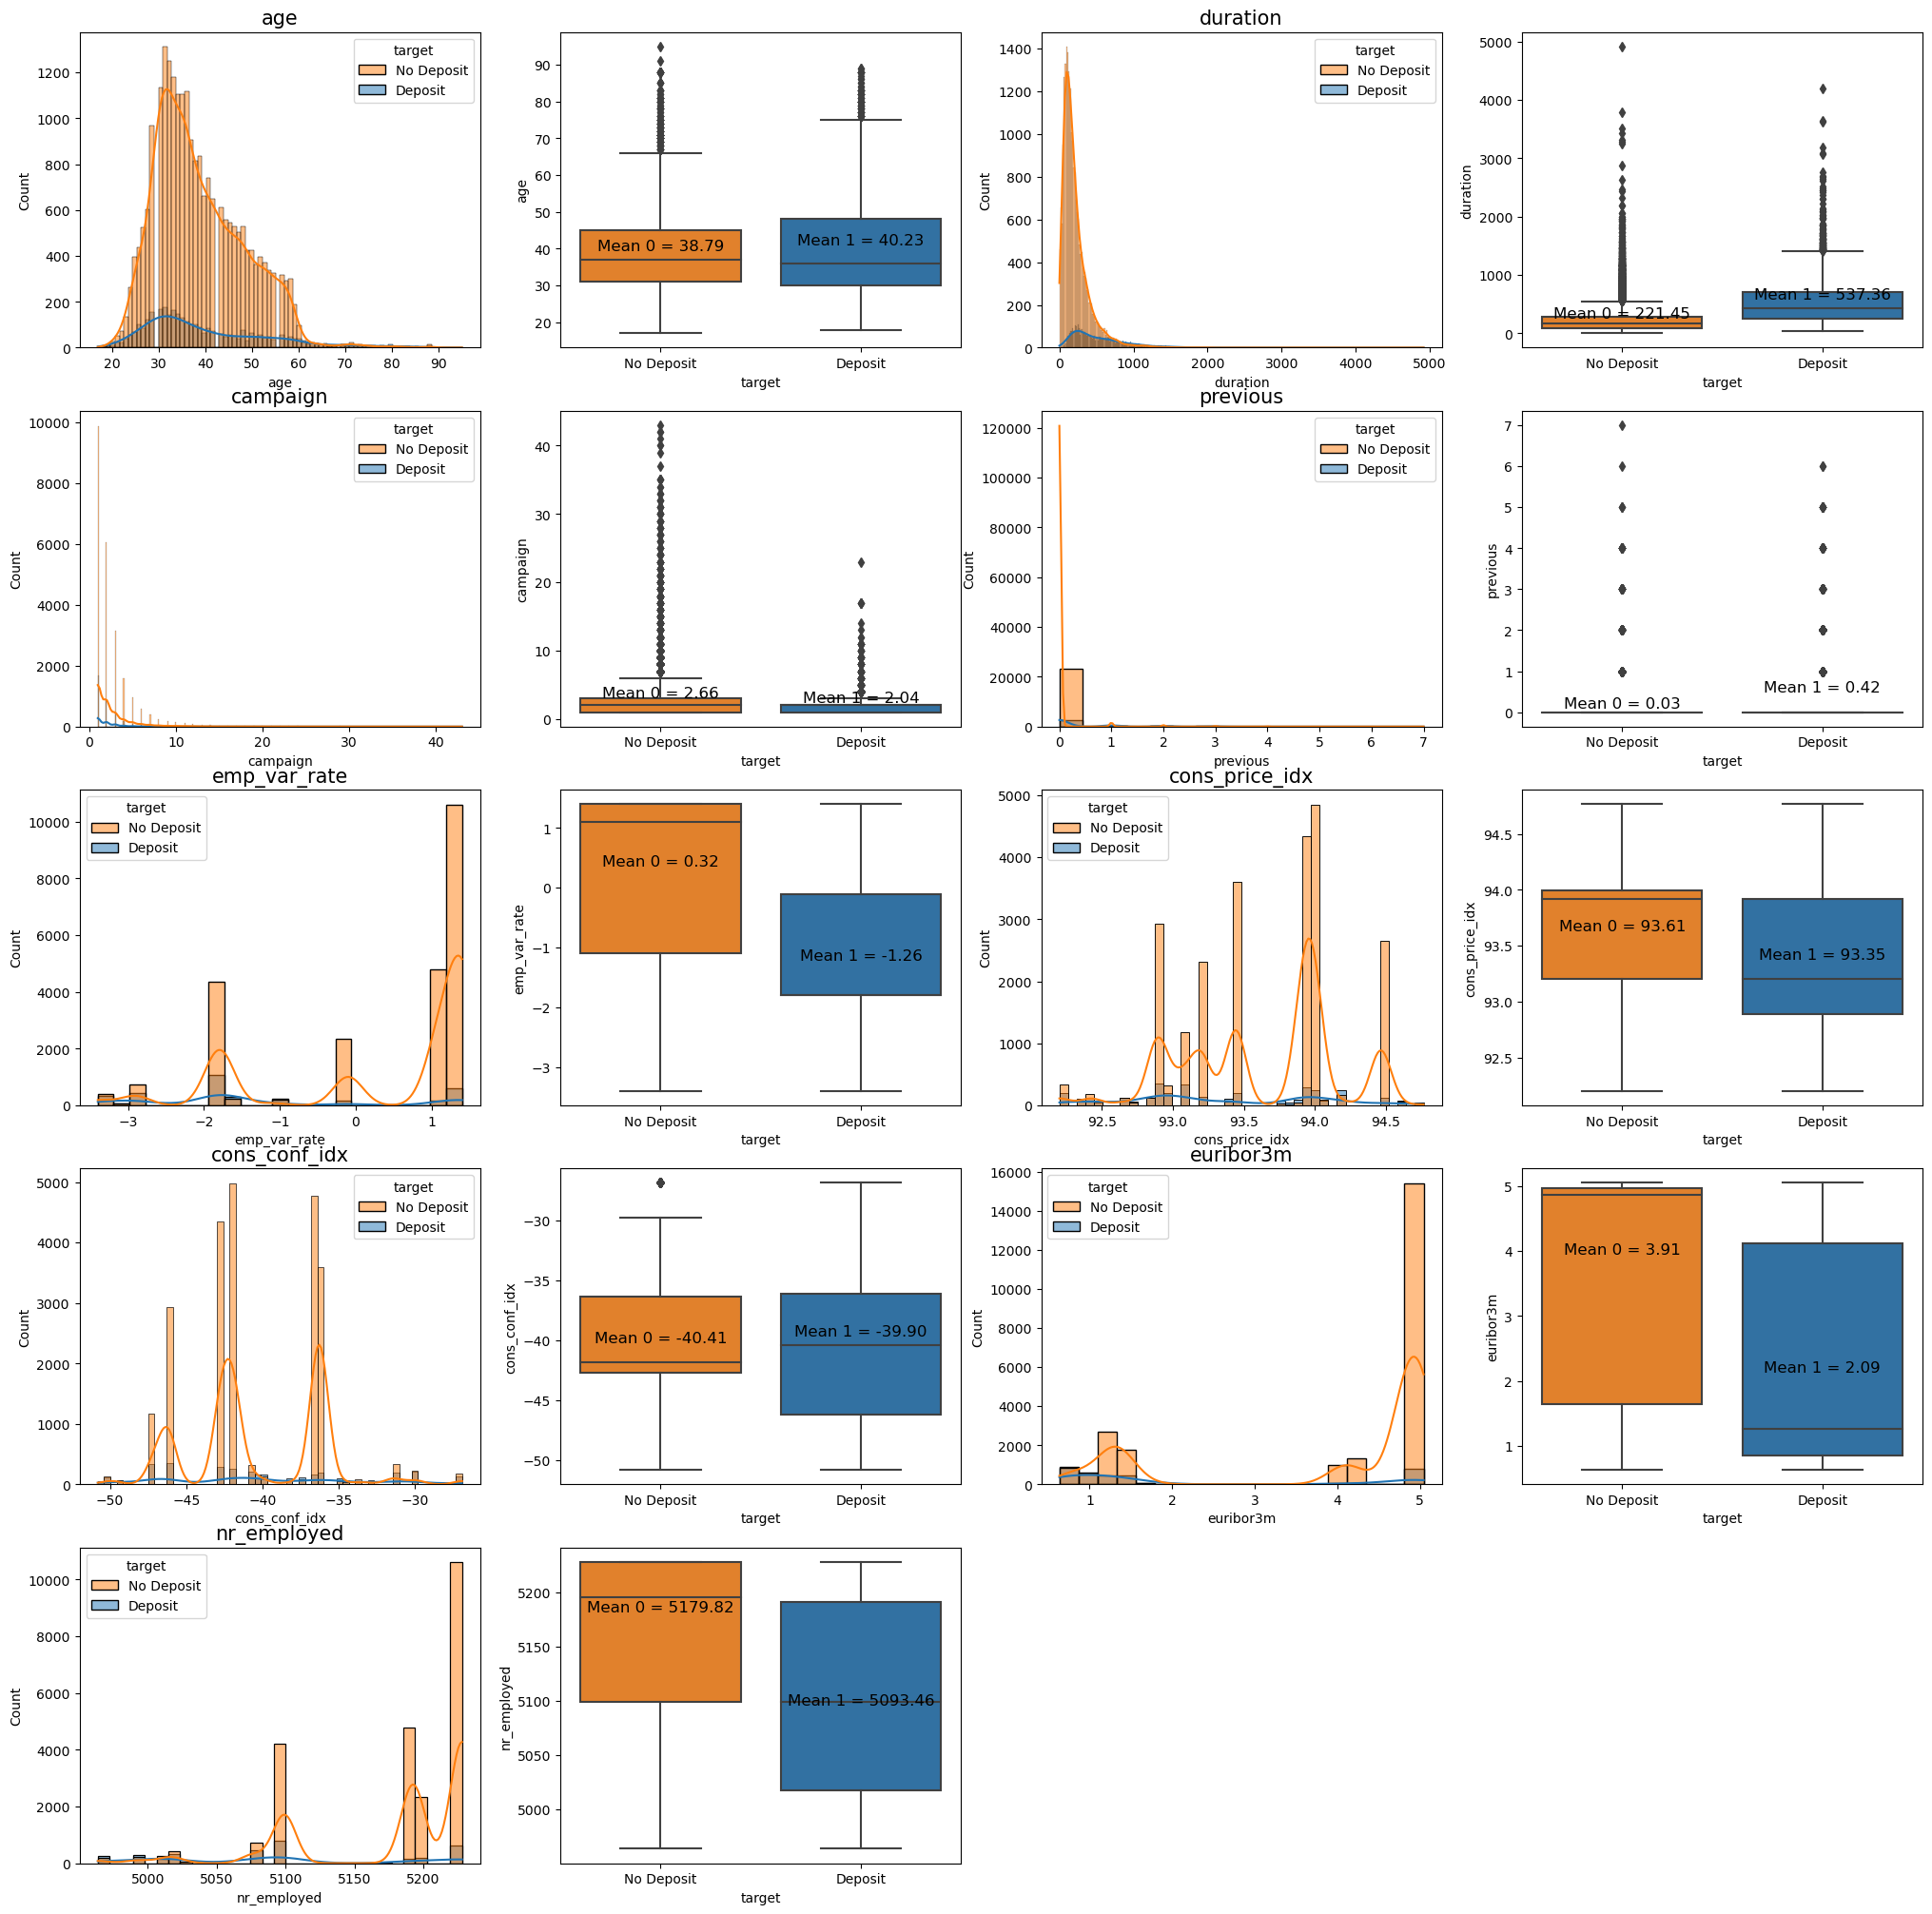

In [63]:
count = 0
fig = plt.figure(figsize=(25,25))
colors = ['#ff7f0e','#2074b4']

for j in df_prep2[numerik_prep].drop(columns=['pdays']).columns:
  count +=1
  plt.subplot(5,4,count)
  sns.histplot(data=df_prep2,x=j,hue=df_prep2['target'],kde=True,palette=colors)
  plt.title(j,fontsize=15)

  count +=1
  ax= plt.subplot(5,4,count)
  sns.boxplot(data=df_prep2,y=j, x=df_prep2['target'], palette=colors)

  # Menghitung median untuk setiap kelompok
  median_0 = df_prep2[df_prep2['target'] == 'No Deposit'][j].mean()
  median_1 = df_prep2[df_prep2['target'] == 'Deposit'][j].mean()

  # Menambahkan teks median di atas diagram boxplot
  ax.text(0, median_0, f'Mean 0 = {median_0:.2f}', ha='center', va='bottom', fontsize=12, color='black')
  ax.text(1, median_1, f'Mean 1 = {median_1:.2f}', ha='center', va='bottom', fontsize=12, color='black')

plt.show()

Berdasarkan hasil boxplot diatas, Persentase perubahan ketenagakerjaan (`emp_var_rate`) dan Total Pekerjaan (`nr_employed`) berkorelasi dengan minat Customer dalam mengambil keputusan melakukan deposito.

Hal ini dapat kita lihat dengan detail sebagai berikut :  
*   `emp_var_rate` memiliki rata-rata No Deposito = **0.32** dan Deposito = **-1.26**
*   `nr_employed` memiliki rata-rata No Deposito = **5179.82** dan Deposito = **5093.46**

Tetapi untuk data ketenagakerjaan adalah hal external yang sulit untuk kita prediksi, mari kita lihat lebih lanjut untuk kolom kategorikal

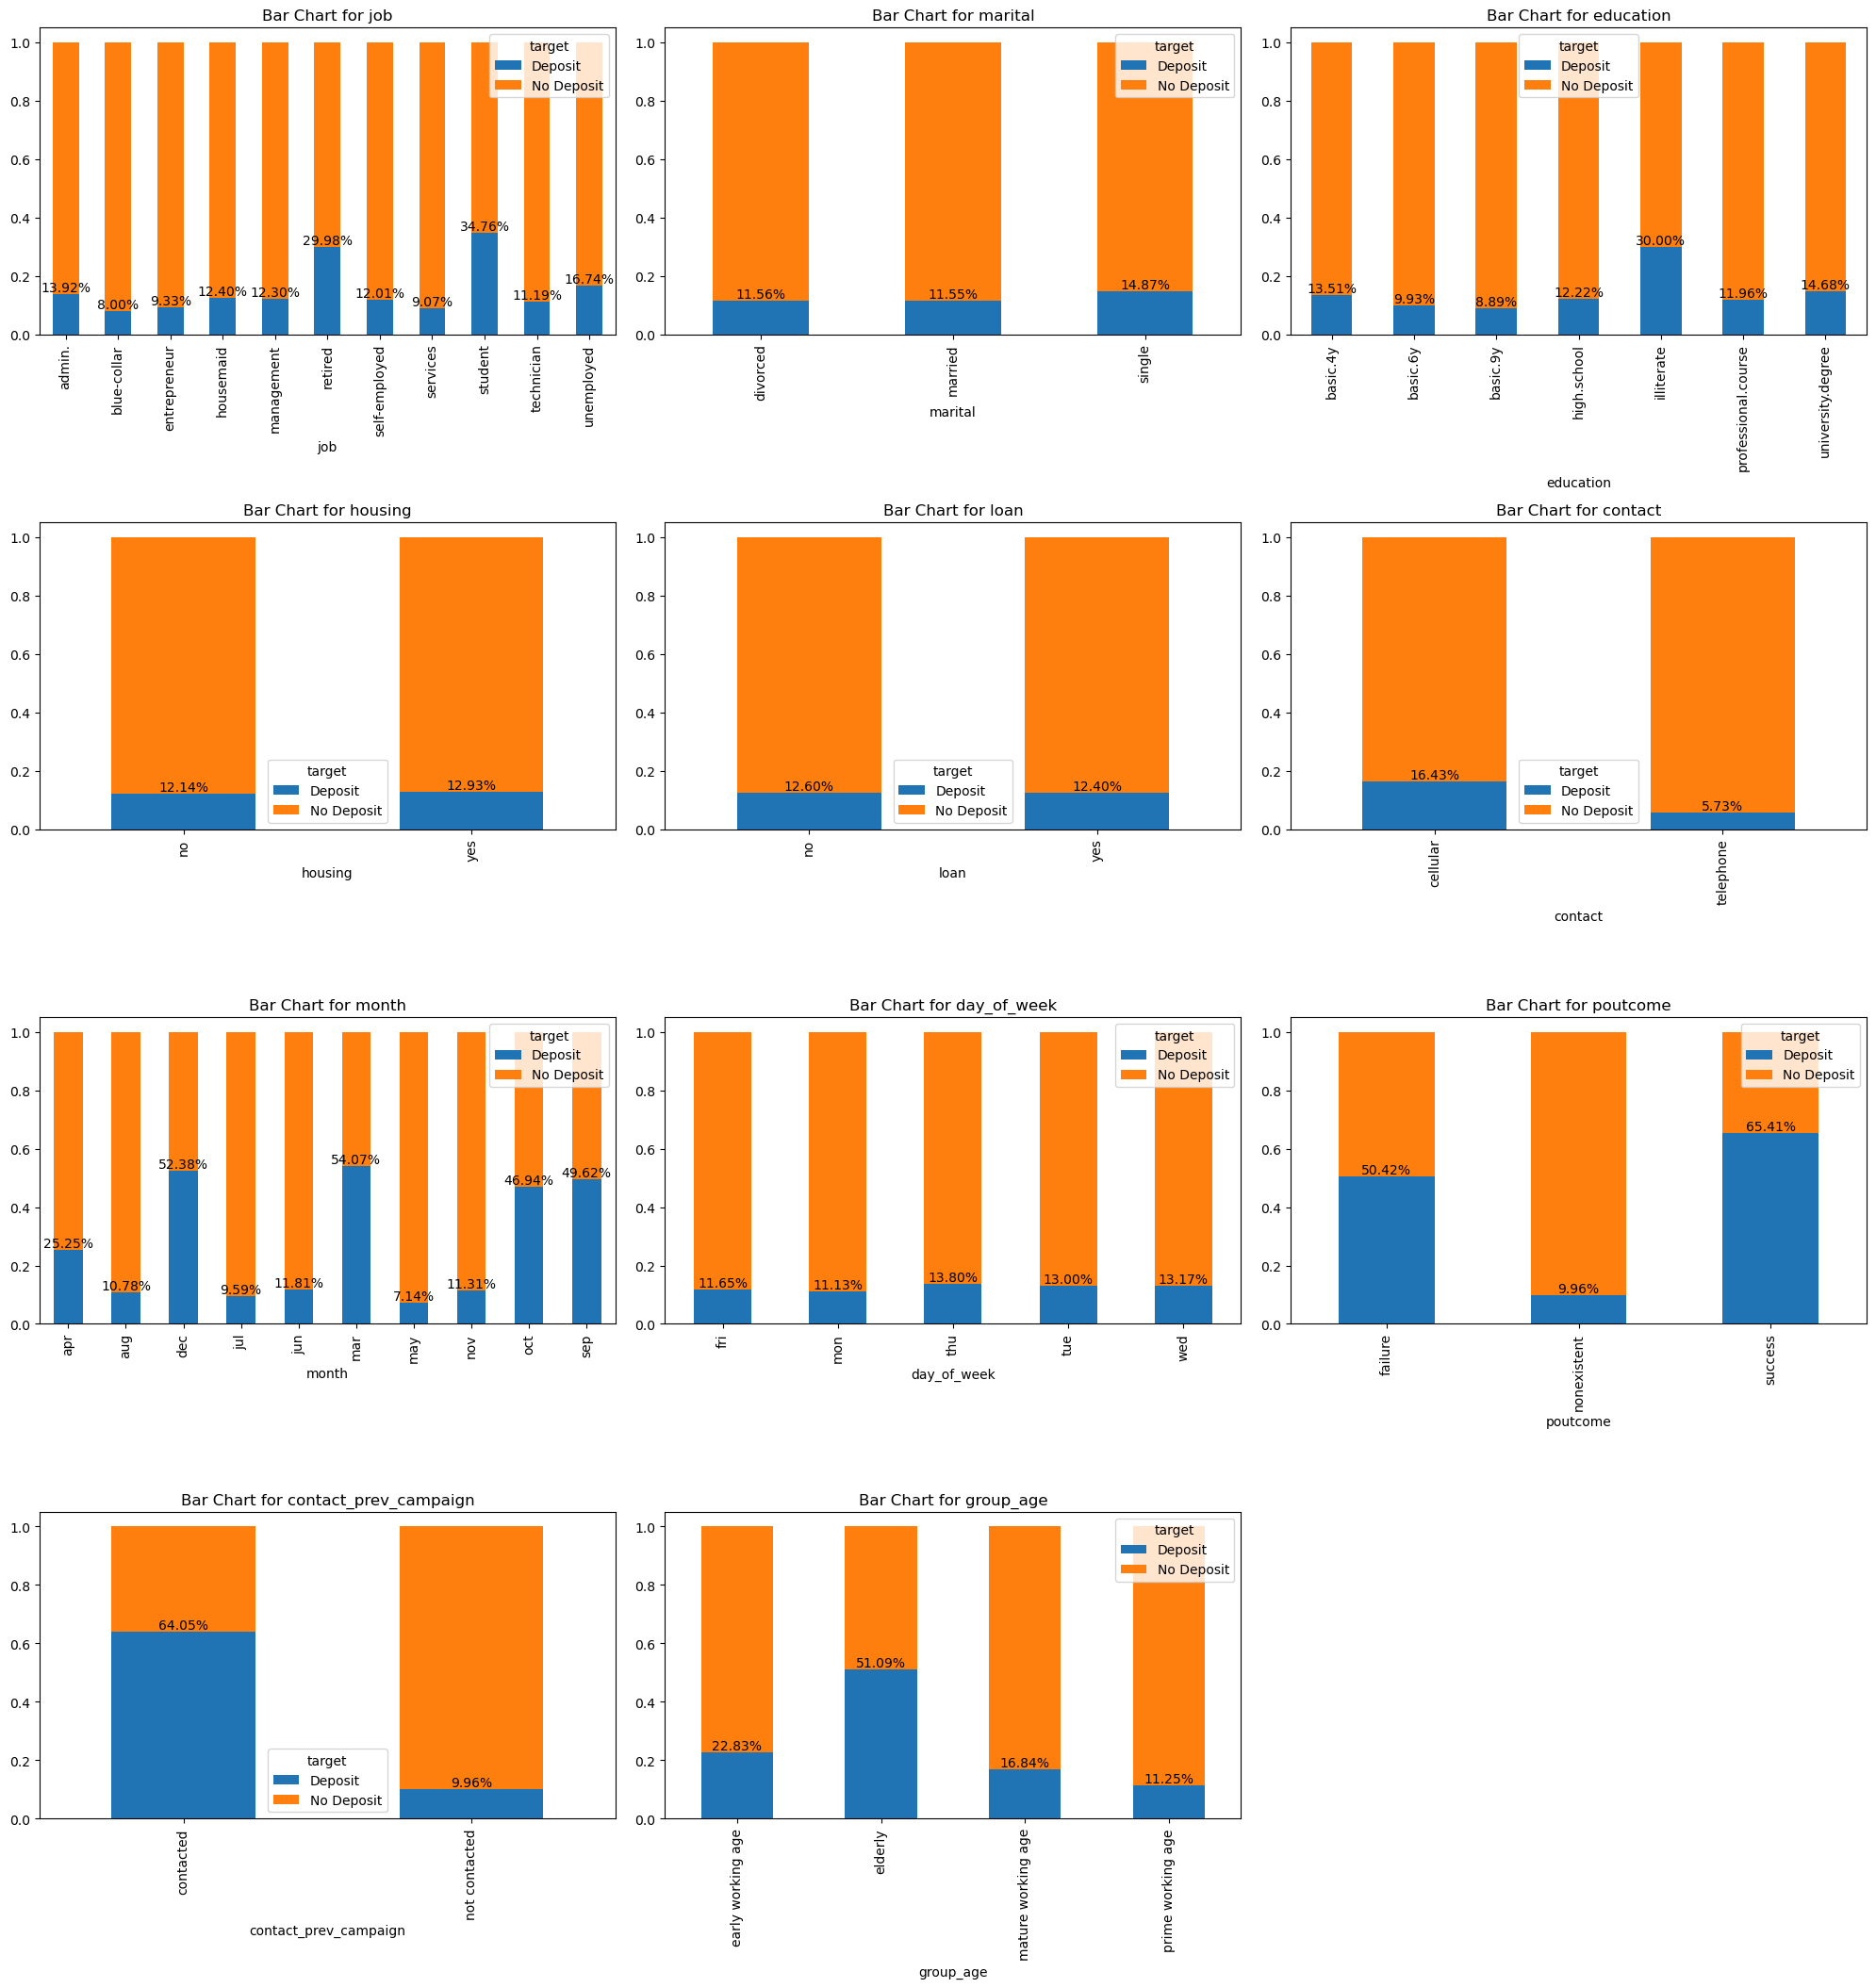

In [64]:
selected_columns = df_prep2[kategorik_prep].drop(columns=['target', 'default']).columns
selected_columns1 = [col for col in selected_columns if df_prep2[col].nunique() <= 4]
selected_columns2 = [col for col in selected_columns if df_prep2[col].nunique() > 4]

count = 0
fig = plt.figure(figsize=(20, 30))  # Menggunakan ukuran gambar yang lebih besar
colors = ['#2074b4', '#ff7f0e']

for i in selected_columns:
    count += 1
    ax = plt.subplot(6, 3, count)
    crosstab_result = pd.crosstab(df_prep2[i], df_prep2['target'], normalize=0)
    ax = crosstab_result.plot(kind='bar', stacked=True, ax=ax, color=colors)
    ax.set_title(f'Bar Chart for {i}')

    for p, deposit in zip(ax.patches, crosstab_result['Deposit']):
        ax.annotate(f'{deposit * 100:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                    va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')


fig.tight_layout()
plt.show()

In [65]:
for i in df_prep2[kategorik_prep].drop(columns=['target','default']).columns:
    relevent_experience_df = df_prep2.groupby(i)['target'].value_counts(normalize=True).unstack()
    display(relevent_experience_df.sort_values(by=['Deposit'], ascending=False))

target,Deposit,No Deposit
job,,
student,0.347573,0.652427
retired,0.299808,0.700192
unemployed,0.167414,0.832586
admin.,0.139192,0.860808
housemaid,0.124019,0.875981
management,0.122979,0.877021
self-employed,0.120123,0.879877
technician,0.111921,0.888079
entrepreneur,0.093264,0.906736


target,Deposit,No Deposit
marital,,
single,0.148655,0.851345
divorced,0.115616,0.884384
married,0.115456,0.884544


target,Deposit,No Deposit
education,,
illiterate,0.300000,0.700000
university.degree,0.146781,0.853219
basic.4y,0.135084,0.864916
high.school,0.122229,0.877771
professional.course,0.119588,0.880412
basic.6y,0.099274,0.900726
basic.9y,0.088942,0.911058


target,Deposit,No Deposit
housing,,
yes,0.129326,0.870674
no,0.121403,0.878597


target,Deposit,No Deposit
loan,,
no,0.125966,0.874034
yes,0.124027,0.875973


target,Deposit,No Deposit
contact,,
cellular,0.164321,0.835679
telephone,0.057257,0.942743


target,Deposit,No Deposit
month,,
mar,0.540741,0.459259
dec,0.523810,0.476190
sep,0.496164,0.503836
oct,0.469428,0.530572
apr,0.252469,0.747531
jun,0.118054,0.881946
nov,0.113053,0.886947
aug,0.107764,0.892236
jul,0.095926,0.904074


target,Deposit,No Deposit
day_of_week,,
thu,0.138028,0.861972
wed,0.131680,0.868320
tue,0.129968,0.870032
fri,0.116514,0.883486
mon,0.111310,0.888690


target,Deposit,No Deposit
poutcome,,
success,0.654072,0.345928
failure,0.504202,0.495798
nonexistent,0.099551,0.900449


target,Deposit,No Deposit
contact_prev_campaign,,
contacted,0.640458,0.359542
not contacted,0.099551,0.900449


target,Deposit,No Deposit
group_age,,
elderly,0.510949,0.489051
early working age,0.228261,0.771739
mature working age,0.168383,0.831617
prime working age,0.112488,0.887512


Berdasarkan barplot dan pie chart diatas, kita dapat menyimpulkan beberapa hal  yaitu :
* Feature `poutcome` status `success` memiliki persentase Deposito sebanyak **65.4%**
* Feature `contact_prev_campaign` status `contacted` memiliki persentase Deposito sebanyak **64%**
* Feature `group_age` status `elderly` memiliki persentase Deposito sebanyak **51%**

Dari 3 feature diatas kita dapat menyimpulkan :  
1.   New Customer = Untuk mencari New Customer kita dapat fokus ke Customer yang sudah memasuki `group_age` `elderly` atau yang umurnya sudah lebih dari 64 tahun. Dimana Customer `elderly` lebih berminat mengambil deposito dibandingkan dengan customer `group_age` yang lain
2.   Customer Repeat Order = Dari banyaknya customer yang melakukan repeat order, kita **Wajib** untuk menawarkan kembali produk deposito kepada customer yang sebelumnya sudah pernah mengambil Deposito.

## Modeling

In [66]:
logreg = LogisticRegression(random_state=23)
knn = KNeighborsClassifier()
gnb = GaussianNB()
dt = DecisionTreeClassifier(random_state=23)
rf = RandomForestClassifier(random_state=23)
xgb = XGBClassifier(random_state=23)
lgbm = lgb.LGBMClassifier(random_state=23)

## Model Benchmark 1
Melakukan pemodelan tanpa menanggulangi imbalanced class pada variabel target

In [67]:
estimator = Pipeline([
    ('prep', transformer),
    ('model', logreg),
])

hyperparam_space = {
    'model':[logreg, knn, gnb, dt, rf, xgb, lgbm]
}

grid_model = GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv= StratifiedKFold(n_splits=10, shuffle=True, random_state=23),
    scoring='roc_auc',
    n_jobs=-1
)

In [68]:
grid_model.fit(X_trainval, y_trainval) 

[LightGBM] [Info] Number of positive: 3097, number of negative: 25115
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 28212, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.109776 -> initscore=-2.093031
[LightGBM] [Info] Start training from score -2.093031


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=23, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['marital',
                                                                          'contact',
                                                                          'poutcome',
                                                                          'contact_prev_campaign']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(mapping=[{'col': 'education',
                                                                                                  'data_type': dtype('O'),
                                                                                                  'mapping': ill...
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=100, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 predictor=None,
                                                 random_state=23, ...),
                                   LGBMClassifier(random_state=23)]},
             scoring='roc_auc')

In [69]:
hasil_grid_model = pd.DataFrame(grid_model.cv_results_)
rekap_grid_model = hasil_grid_model[['param_model','mean_test_score','std_test_score','rank_test_score']].sort_values(by='rank_test_score', ascending=True).reset_index(drop='first')
rekap_grid_model

,param_model,mean_test_score,std_test_score,rank_test_score
0,LGBMClassifier(random_state=23),0.788598,0.013331,1
1,"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=23, ...)",0.776365,0.011550,2
2,LogisticRegression(random_state=23),0.769214,0.014622,3
3,GaussianNB(),0.768950,0.015424,4
4,RandomForestClassifier(random_state=23),0.751966,0.009402,5
5,KNeighborsClassifier(),0.707573,0.015267,6
6,DecisionTreeClassifier(random_state=23),0.628862,0.012386,7


## Model Benchmark 2
Melakukan pemodelan menggunakan scaler tanpa menanggulangi imbalanced class pada variabel target 

In [70]:
estimator = Pipeline([
    ('prep', transformer),
    ('scaler', StandardScaler()),
    ('model', logreg),
])

hyperparam_space = {
    'scaler':[StandardScaler(), RobustScaler()],
    'model':[logreg, knn, gnb, dt, rf, xgb,lgbm]
}

grid_model_scaler = GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv= StratifiedKFold(n_splits=10, shuffle=True, random_state=23),
    scoring='roc_auc',
    n_jobs=-1
)

In [71]:
grid_model_scaler.fit(X_trainval, y_trainval) 

[LightGBM] [Info] Number of positive: 3097, number of negative: 25115
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 28212, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.109776 -> initscore=-2.093031
[LightGBM] [Info] Start training from score -2.093031


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=23, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['marital',
                                                                          'contact',
                                                                          'poutcome',
                                                                          'contact_prev_campaign']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(mapping=[{'col': 'education',
                                                                                                  'data_type': dtype('O'),
                                                                                                  'mapping': ill...
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=100, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 predictor=None,
                                                 random_state=23, ...),
                                   LGBMClassifier(random_state=23)],
                         'scaler': [StandardScaler(), RobustScaler()]},
             scoring='roc_auc')

In [72]:
hasil_grid_model_scaler = pd.DataFrame(grid_model_scaler.cv_results_)
rekap_grid_model_scaler = hasil_grid_model_scaler[['param_model','param_scaler','mean_test_score','std_test_score','rank_test_score']].sort_values(by='rank_test_score', ascending=True).reset_index(drop='first')
rekap_grid_model_scaler

,param_model,param_scaler,mean_test_score,std_test_score,rank_test_score
0,LGBMClassifier(random_state=23),RobustScaler(),0.788593,0.013332,1
1,LGBMClassifier(random_state=23),StandardScaler(),0.788392,0.013643,2
2,"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=23, ...)",RobustScaler(),0.776367,0.011550,3
3,"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=23, ...)",StandardScaler(),0.776345,0.011538,4
4,LogisticRegression(random_state=23),StandardScaler(),0.770172,0.013907,5
5,LogisticRegression(random_state=23),RobustScaler(),0.770165,0.013905,6
6,GaussianNB(),StandardScaler(),0.768950,0.015424,7
7,GaussianNB(),RobustScaler(),0.768950,0.015424,7
8,RandomForestClassifier(random_state=23),StandardScaler(),0.752197,0.009093,9
9,RandomForestClassifier(random_state=23),RobustScaler(),0.752059,0.009917,10


## Membandingkan Model Benchmark 1 dan 2

In [73]:
display(rekap_grid_model, rekap_grid_model_scaler)

,param_model,mean_test_score,std_test_score,rank_test_score
0,LGBMClassifier(random_state=23),0.788598,0.013331,1
1,"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=23, ...)",0.776365,0.011550,2
2,LogisticRegression(random_state=23),0.769214,0.014622,3
3,GaussianNB(),0.768950,0.015424,4
4,RandomForestClassifier(random_state=23),0.751966,0.009402,5
5,KNeighborsClassifier(),0.707573,0.015267,6
6,DecisionTreeClassifier(random_state=23),0.628862,0.012386,7


,param_model,param_scaler,mean_test_score,std_test_score,rank_test_score
0,LGBMClassifier(random_state=23),RobustScaler(),0.788593,0.013332,1
1,LGBMClassifier(random_state=23),StandardScaler(),0.788392,0.013643,2
2,"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=23, ...)",RobustScaler(),0.776367,0.011550,3
3,"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimators=100, n_jobs=None, num_parallel_tree=None,\n predictor=None, random_state=23, ...)",StandardScaler(),0.776345,0.011538,4
4,LogisticRegression(random_state=23),StandardScaler(),0.770172,0.013907,5
5,LogisticRegression(random_state=23),RobustScaler(),0.770165,0.013905,6
6,GaussianNB(),StandardScaler(),0.768950,0.015424,7
7,GaussianNB(),RobustScaler(),0.768950,0.015424,7
8,RandomForestClassifier(random_state=23),StandardScaler(),0.752197,0.009093,9
9,RandomForestClassifier(random_state=23),RobustScaler(),0.752059,0.009917,10


Berdasarkan hasil pemodelan di atas, dapat dilihat bahwa algoritma terbaik adalah LGBM, meskipun telah mencoba memodelkan dengan scaler, hasil metrik evaluasi tetap tidak naik secara signifikan. Oleh karena itu model terpilih adalah LGBM tanpa menggunakan scaler.

## Prediksi LGBM data test (1)

In [74]:
lgbm = lgb.LGBMClassifier(random_state=23)

model_lgbm = Pipeline([
    ('prep', transformer),
    ('model', lgbm)
    ])

model_lgbm.fit(X_trainval, y_trainval)

[LightGBM] [Info] Number of positive: 3097, number of negative: 25115
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 175
[LightGBM] [Info] Number of data points in the train set: 28212, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.109776 -> initscore=-2.093031
[LightGBM] [Info] Start training from score -2.093031


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['marital', 'contact',
                                                   'poutcome',
                                                   'contact_prev_campaign']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'education',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': illiterate             1
basic.4y               2
basic.6y               3
basic.9y               4
high.school            5
university.degree      6
professional.course    7
dtype: int64},
                                                                          {'col': 'month',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': mar     1
apr     2
may     3
jun     4
jul     5
aug     6
sep     7
oct     8
nov     9
dec    10
dtype: int64},
                                                                          {'col': 'day_of_week',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': mon    1
tue    2
wed    3
thu    4
fri    5
dtype: int64}]),
                                                  ['education', 'month',
                                                   'day_of_week']),
                                                 ('binary', BinaryEncoder(),
                                                  ['job'])])),
                ('model', LGBMClassifier(random_state=23))])

In [75]:
y_pred = model_lgbm.predict(X_test)
y_pred_prob = model_lgbm.predict_proba(X_test)

hasil_pred = pd.DataFrame()
hasil_pred['Model'] = ['LGBM']
hasil_pred['ROC'] = [roc_auc_score(y_test, y_pred_prob[:,1])]
hasil_pred['Recall'] = [recall_score(y_test, y_pred)]
hasil_pred['Precision'] = [precision_score(y_test, y_pred)]

hasil_pred

,Model,ROC,Recall,Precision
0,LGBM,0.801995,0.262274,0.650641


Dapat dilihat hasil pemodelan di atas, ROC menadapatkan nilai 0.8, namun saat dilihat pada recall nilai tersebut sangat kecil dibanding dengan precision. Hal tersebut memperlihatkan bahwa model memiliki FN yang lebih besar dibanding FP, artinya model kurang baik dalam memprediksi kelas positif (kelas 1) atau dalam kasus ini adalah nasabah yang membuka deposito, fenomena itu dapat mengakibatkan bank kehilangan nasabah yang akan membuka deposito sehingga dana kelolaan yang didapat tidak maksimal. Hal tersebut dapat diakibatkan karena fenomena imbalanced class belum ditanggulangi. Oleh karena itu kita akan mencoba menanggulangi fenomena tersebut dengan sampling.

## Model LGBM + Sampling

Kali ini kita akan mecoba pemodelan dengan menggunakan algoritma LGBM namun ditambah dengan proses sampling, proses sampling yang digunakan ada 3 macam yaitu SMOTE, random udersampling, dan random oversampling.

- **Random oversampling** menduplikasi titik data dari kelas minoritas secara acak, metode ini terkenal dapat meningkatkan performansi metrik evaluasi, namun perlu diperhatikan metode ini dapat membuat model overfitting kepada kelas yang diduplikasi. 
- **Random undersampling** membuang amatan dari kelas mayoritas secara acak, metode ini paling sederhana, namun metode ini dapat mengakibatkan informasi data hilang
- **SMOTE** merupakan singkatan dari synthetic minority oversampling. Metode ini adalah metode oversampling untuk menyeimbangkan distribusi kelas yang ada. Algoritma ini akan melakukan sintesis kelas minoritas berdasarkan jarak (distanced based). 



In [76]:
smote = SMOTE(random_state=23)
rus = RandomUnderSampler(random_state=23)
ros = RandomOverSampler(random_state=23)

In [77]:
estimator = Pipeline([
    ('prep',transformer),
    ('sampling',ros),
    ('model',lgbm)
])

hyperparam_space = {
    'sampling':[smote, rus, ros]
}

grid_model_sampling = GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv= StratifiedKFold(n_splits=10, shuffle=True, random_state=23),
    scoring='roc_auc',
    n_jobs=-1
)

In [78]:
grid_model_sampling.fit(X_trainval, y_trainval) 

[LightGBM] [Info] Number of positive: 25115, number of negative: 25115
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4331
[LightGBM] [Info] Number of data points in the train set: 50230, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=23, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['marital',
                                                                          'contact',
                                                                          'poutcome',
                                                                          'contact_prev_campaign']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(mapping=[{'col': 'education',
                                                                                                  'data_type': dtype('O'),
                                                                                                  'mapping': ill...
                                                                                                  'mapping': mon    1
tue    2
wed    3
thu    4
fri    5
dtype: int64}]),
                                                                         ['education',
                                                                          'month',
                                                                          'day_of_week']),
                                                                        ('binary',
                                                                         BinaryEncoder(),
                                                                         ['job'])])),
                                       ('sampling',
                                        RandomOverSampler(random_state=23)),
                                       ('model',
                                        LGBMClassifier(random_state=23))]),
             n_jobs=-1,
             param_grid={'sampling': [SMOTE(random_state=23),
                                      RandomUnderSampler(random_state=23),
                                      RandomOverSampler(random_state=23)]},
             scoring='roc_auc')

In [79]:
hasil_grid_model_sampling = pd.DataFrame(grid_model_sampling.cv_results_)
rekap_grid_model_sampling = hasil_grid_model_sampling[['param_sampling','mean_test_score','std_test_score','rank_test_score']].sort_values(by='rank_test_score', ascending=True).reset_index(drop='first')
rekap_grid_model_sampling

,param_sampling,mean_test_score,std_test_score,rank_test_score
0,SMOTE(random_state=23),0.789135,0.012400,1
1,RandomOverSampler(random_state=23),0.787823,0.010227,2
2,RandomUnderSampler(random_state=23),0.783613,0.013351,3


Dapat dilihat hasil pemodelan LGBM dengan sampling, metode SMOTE menjadi metode yang memiliki nilai ROC AUC paling tinggi, nilainya sedikit lebih tinggi dibanding metode lainnya, namun perlu diperhatikan nilai standar deviasi yang dihasilkan. Metode yang memiliki nilai standar deviasi paling kecil adalah ROS. Hal tersebut menandakan bahwa model dengan menggunakan metode ROS lebih stabil dibanding metode lainnya. Oleh karena itu metode sampling terpilih adalah ROS.

## Hyperparameter tuning LGM + ROS

- max depth = limit untuk menentukan kedalam pohon (default -1)
- min child weight = minimal sum hessian dalam leaf, dapat digunakan untuk menanggulangi over-fitting (default 0.01, constraint >= 0)
- subsample = untuk memilih data secara acak tanpa resampling (default 1, constraint 0.0 < x > 1.0)
- colsampe bytree = untuk memlih subset fitur secara acak dalam setiap iterasi pohon (default 1, constraint 0.0 < x > 1.0)
- reg alpga = L1 regularization (default 0, constraint >= 0.0)
- reg lambda = L2 regularization (default 0, constraint >= 0.0)  # L1 dan L2 regularization merupakan parameter untuk mencegah overfitting di machine leanring. 
- n estimators = jumlah iterasi pohon (default 100, constraint >= 0)
- learning rate = untuk menentukan shrinkage rate (default 0.1, constraint >= 0.0)
- random state = untuk mendapatkan hasil yang sama
- num leaves = limit max jumlah leaves dalam satu pohon (default 31, constraint 1 < x > 131072)

source: https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [80]:
estimator=Pipeline([
    ('prep',transformer),
    ('sampling',ros),
    ('model',lgbm)
])

hyperparam_space = {
    # 'model__max_depth': [5, 7, 9],
    # 'model__min_child_weight': [10, 20, 30],
    # 'model__subsample': [0.6, 0.8],
    # 'model__colsample_bytree': [0.6, 0.8],
    # 'model__reg_alpha': [0.0, 0.1, 1.0],
    # 'model__reg_lambda': [0.0, 0.1, 1.0],
    # 'model__n_estimators': [100, 200, 300],
    # 'model__learning_rate': [0.01, 0.1, 0.2],
    # 'model__random_state': [23]

    'model__max_depth': [9],
    'model__min_child_weight': [20],
    'model__subsample': [0.2],
    'model__colsample_bytree': [0.8],
    'model__reg_alpha': [0.1],
    'model__reg_lambda': [0.1],
    'model__n_estimators': [300],
    'model__learning_rate': [0.01],
    'model__random_state': [23],
    'model__num_leaves' :[31],
    'model__class_weight' :['balanced']

    # 'model__max_depth': [5, 7],
    # 'model__min_child_weight': [5, 10],
    # 'model__subsample': [0.6, 0.8],
    # 'model__colsample_bytree': [0.6, 0.8],
    # 'model__reg_alpha': [0.0, 0.1],
    # 'model__reg_lambda': [0.0, 0.1],
    # 'model__n_estimators': [100, 300],
    # 'model__learning_rate': [0.01, 0.1],
    # 'model__random_state': [23]
    
}

crossval = StratifiedKFold(n_splits=10, shuffle=True, random_state=23)

grid_model_sampling_tuning = GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv = crossval,
    scoring='roc_auc',
    n_jobs=-1, 
)

In [81]:
grid_model_sampling_tuning.fit(X_trainval, y_trainval) 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 25115, number of negative: 25115
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 50230, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=23, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['marital',
                                                                          'contact',
                                                                          'poutcome',
                                                                          'contact_prev_campaign']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(mapping=[{'col': 'education',
                                                                                                  'data_type': dtype('O'),
                                                                                                  'mapping': ill...
                                        LGBMClassifier(random_state=23))]),
             n_jobs=-1,
             param_grid={'model__class_weight': ['balanced'],
                         'model__colsample_bytree': [0.8],
                         'model__learning_rate': [0.01],
                         'model__max_depth': [9],
                         'model__min_child_weight': [20],
                         'model__n_estimators': [300],
                         'model__num_leaves': [31], 'model__random_state': [23],
                         'model__reg_alpha': [0.1], 'model__reg_lambda': [0.1],
                         'model__subsample': [0.2]},
             scoring='roc_auc')

In [82]:
hasil_grid_model_sampling_tuning = pd.DataFrame(grid_model_sampling_tuning.cv_results_)

display(grid_model_sampling_tuning.best_params_, 
        grid_model_sampling_tuning.best_score_)

{'model__class_weight': 'balanced',
 'model__colsample_bytree': 0.8,
 'model__learning_rate': 0.01,
 'model__max_depth': 9,
 'model__min_child_weight': 20,
 'model__n_estimators': 300,
 'model__num_leaves': 31,
 'model__random_state': 23,
 'model__reg_alpha': 0.1,
 'model__reg_lambda': 0.1,
 'model__subsample': 0.2}

0.792962503978775

## Prediksi LGBM + ROS + Tuning data test (2)

In [83]:
grid_model_sampling_tuning.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['marital', 'contact',
                                                   'poutcome',
                                                   'contact_prev_campaign']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'education',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': illiterate             1
basic.4y               2
basic.6y               3
basic.9y               4
high.school            5
university.degree      6
professional.course...
tue    2
wed    3
thu    4
fri    5
dtype: int64}]),
                                                  ['education', 'month',
                                                   'day_of_week']),
                                                 ('binary', BinaryEncoder(),
                                                  ['job'])])),
                ('sampling', RandomOverSampler(random_state=23)),
                ('model',
                 LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
                                learning_rate=0.01, max_depth=9,
                                min_child_weight=20, n_estimators=300,
                                random_state=23, reg_alpha=0.1, reg_lambda=0.1,
                                subsample=0.2))])

In [84]:
model_lgbm_sampling_tuning = grid_model_sampling_tuning.best_estimator_
model_lgbm_sampling_tuning.fit(X_trainval, y_trainval)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 25115, number of negative: 25115
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 50230, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['marital', 'contact',
                                                   'poutcome',
                                                   'contact_prev_campaign']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'education',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': illiterate             1
basic.4y               2
basic.6y               3
basic.9y               4
high.school            5
university.degree      6
professional.course...
tue    2
wed    3
thu    4
fri    5
dtype: int64}]),
                                                  ['education', 'month',
                                                   'day_of_week']),
                                                 ('binary', BinaryEncoder(),
                                                  ['job'])])),
                ('sampling', RandomOverSampler(random_state=23)),
                ('model',
                 LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
                                learning_rate=0.01, max_depth=9,
                                min_child_weight=20, n_estimators=300,
                                random_state=23, reg_alpha=0.1, reg_lambda=0.1,
                                subsample=0.2))])

In [85]:
y_pred_sampling_tuning = model_lgbm_sampling_tuning.predict(X_test)
y_pred_prob_sampling_tuning = model_lgbm_sampling_tuning.predict_proba(X_test)

hasil_pred_sampling_tuning = pd.DataFrame()
hasil_pred_sampling_tuning['Model'] = ['LGBM + ROS + Tuning']
hasil_pred_sampling_tuning['ROC'] = [roc_auc_score(y_test, y_pred_prob_sampling_tuning[:,1])]
hasil_pred_sampling_tuning['Recall'] = [recall_score(y_test, y_pred_sampling_tuning)]
hasil_pred_sampling_tuning['Precision'] = [precision_score(y_test, y_pred_sampling_tuning)]

hasil_pred_sampling_tuning

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,Model,ROC,Recall,Precision
0,LGBM + ROS + Tuning,0.810342,0.630491,0.387917


Hasil model LGBM + ROS + Tuning mendapatkan nilai 0.8, namun nilai precision model sangat kecil dibanding dengan recall. Hal tersebut memperlihatkan bahwa model mimiliki FP yang lebih besar dibanding FN, artinya model kurang baik dalam memprediksi kelas negatif (kelas 0) atau dalam kasus ini adalah nabasah yang tidak membuka deposito, fenomena itu mengakibatkan sumber daya yang dikeluarkan bank menjadi sia-sia.

## Membandingkan hasil prediksi data test (1) dan (2)

In [86]:
display(hasil_pred, hasil_pred_sampling_tuning)

,Model,ROC,Recall,Precision
0,LGBM,0.801995,0.262274,0.650641


,Model,ROC,Recall,Precision
0,LGBM + ROS + Tuning,0.810342,0.630491,0.387917


In [87]:
report_model = classification_report(y_test, y_pred)
report_model_sampling_tuning = classification_report(y_test, y_pred_sampling_tuning)

print('Classification Report Default LGBM : \n', report_model)
print('Classification Report Tuned LGBM : \n', report_model_sampling_tuning)

Classification Report Default LGBM : 
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      6279
           1       0.65      0.26      0.37       774

    accuracy                           0.90      7053
   macro avg       0.78      0.62      0.66      7053
weighted avg       0.89      0.90      0.88      7053

Classification Report Tuned LGBM : 
               precision    recall  f1-score   support

           0       0.95      0.88      0.91      6279
           1       0.39      0.63      0.48       774

    accuracy                           0.85      7053
   macro avg       0.67      0.75      0.70      7053
weighted avg       0.89      0.85      0.87      7053



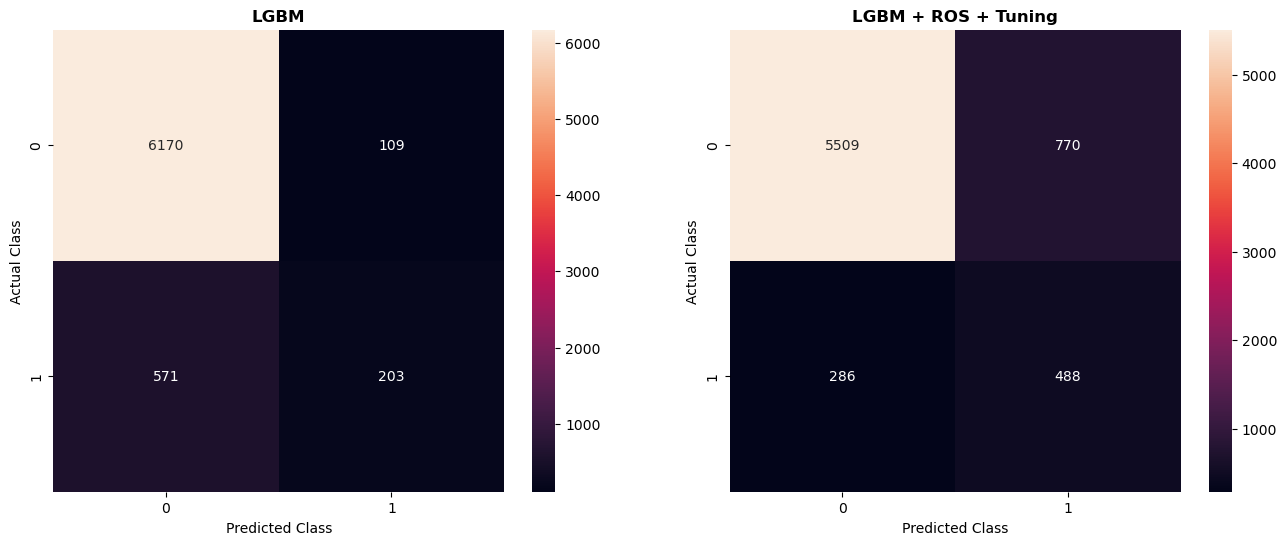

In [88]:
plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g').set_title('LGBM', weight = 'bold')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, y_pred_sampling_tuning), annot=True, fmt='g').set_title('LGBM + ROS + Tuning', weight = 'bold')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

plt.show()

Berdasarkan perbandingan model data test (1) dan (2) di atas, dapat dilihat bahwa model LGBM + ROS + Tuning meningkatkan nilai metrik evaluasi ROC dan recall, namun metrik evaluasi precision turun. Berdasarkan hal tersebut ada pertukuran nilai recall dan precision antara model LGBM dengan model LGBM + ROS + Tuning. 

Model LGBM memiliki jumlah FN > FP, sedangkan model LGBM + ROS + Tuning memiliki jumlah FN < FP. Oleh karena itu model terpilih harus model yang dapat menguntungkan bank lebih banyak. Sesuai deskripsi sebelumnya bahwa FN menandakan bahwa bank kehilangan nasabah yang berpotensi untuk membuka deposito sedangkan FP menandakan bank mengeluarkan sumber daya yang sia-sia dalam campaign telemarketing. Sehingga perlu diperhitungkan opportunity cost yang dialami oleh bank. 

Seperti yang kita ketahui umunya untuk membuka deposito diperlukan nominal tertentu, dimana nominal tersebut relatif cukup besar, serta perlu mempersiapkan biaya-biaya lain contohnya seperti biaya adminstrasi. Berdasarkan hal tersebut kita sudah tahu akan banyak dana yang masuk ke dalam bank, sehingga dapat memaksimalkan dana kelolaan bank. Biaya yang dikeluarkan (cost per call) dalam telemarketing berkisar antara 2.7 - 5.6 $ [(Carter, 2023)](https://www.cxtoday.com/contact-centre/how-to-calculate-your-cost-per-inbound-outbound-call-and-why/). Fakta-fakta tersebut menunjukan akan lebih menguntungkan bank apabila **tidak** kehilangan nasabah yang cenderung untuk membuka deposito dibanding mengeluarkan biaya hanya untuk telemarketing. Dengan kata lain model dengan FN < FP lebih menguntungkan bank.

Oleh karena itu untuk kasus ini model yang dipilih adalah LGBM + ROS + Tuning, dikarenakan perhitungan di atas, serta memiliki nilai ROC yang sedikit lebih tinggi.

______
LightGBM merupakan gradient boosing framework yang menggunakan tree based learning algorithm. Waktu komputasi LightGBM lebih cepat dibandingkan dengan XGBoost namun masih dapat memiliki performansi yang sama.

source:
- https://neptune.ai/blog/xgboost-vs-lightgbm
- https://lightgbm.readthedocs.io/en/latest/

## Feature Importance Model LGBM + ROS + Tuning

In [89]:
rekap = pd.DataFrame()
rekap['var'] = transformer.get_feature_names_out()
rekap['coef'] = model_lgbm_sampling_tuning['model'].feature_importances_
rekap.sort_values(ascending=False, by='coef').reset_index(drop='first')

,var,coef
0,remainder__age,1924
1,ordinal__month,1505
2,remainder__campaign,1292
3,ordinal__day_of_week,1003
4,ordinal__education,737
5,remainder__emp_var_rate,719
6,onehot__contact_telephone,302
7,binary__job_3,239
8,binary__job_1,233
9,binary__job_0,219


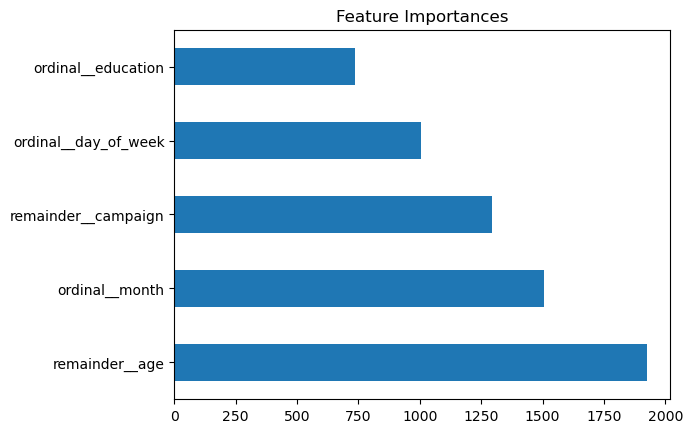

In [90]:
coef1 = pd.Series(model_lgbm_sampling_tuning['model'].feature_importances_, transformer.get_feature_names_out()).sort_values(ascending = False).head(5)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

Berdasarkan visualisasi feature importance di atas, dapat kita lihat bahwa 5 urutan fitur paling penting untuk model ini adalah `age`, `month`, `campaign`, `day_of_week`, dan `education`. Artinya demografik umur  dan pendidikan nasabah paling menentukan apakah  akan membuka deposito atau tidak. Lalu penentuan jumlah kontak dan waktu kontak sangat penting untuk diperhatikan oleh bank karena menjadi penentu nasabah akan membuka depostio atau tidak.

# Kesimpulan dan Rekomendasi

## Kesimpulan

- Model terpilih adalah LGBM + ROS + Tuning. Model tersebut terpilih karena memiliki nilai ROC yang paling tinggi serta merupakan model yang paling menguntungkan untuk bank karena memiliki jumlah FN yang lebih kecil dibandingkan model satunya. 
- fitur yang paling mempengaruhi dalam model adalah 
    - age
    - month
    - campaign
    - day_of_week
    - education

- limitasi model dapat dilihat dari nilai minimum dan maksimum fitur numerik serta data unique pada fitur kategorik. Apabila menggunakan nilai diluar rentang tersebut hasil model menjadi bias.

In [91]:
kategorik_prep = df_prep.columns[df_prep.dtypes == object]
listItem = []
for col in kategorik_prep :
    listItem.append( [col, df_prep.sort_values(col)[col].unique()])

limitasi = pd.DataFrame(columns=['Nama','Data Unique'],
                     data=listItem)

display(df_prep.drop('target', axis = 1).describe().loc[['min', 'max']], limitasi)

,age,campaign,previous,emp_var_rate
min,17.0,1.0,0.0,-3.4
max,98.0,56.0,7.0,1.4


,Nama,Data Unique
0,job,"[admin., blue-collar, entrepreneur, housemaid, management, retired, self-employed, services, student, technician, unemployed]"
1,marital,"[divorced, married, single]"
2,education,"[basic.4y, basic.6y, basic.9y, high.school, illiterate, professional.course, university.degree]"
3,contact,"[cellular, telephone]"
4,month,"[apr, aug, dec, jul, jun, mar, may, nov, oct, sep]"
5,day_of_week,"[fri, mon, thu, tue, wed]"
6,poutcome,"[failure, nonexistent, success]"
7,contact_prev_campaign,"[contacted, not contacted]"


Sekarang kita coba ilustrasikan antara tidak menggunakan model dengan menggunakan model berdasarkan hasil confusion matrix yang didapat. Berdasarkan biaya cost per call pada bagian perbandingan model, kita asumsikan untuk kasus ini biaya tersebut sebesar 4.15 $.

Hasil confusion matrix:
- TP = 488
- TN = 5509
- FN = 286
- FP = 770
- Total Nasabah = 7053

**Tidak menggunakan model** <br>
Apabila kita tidak menggunakan model data nasabah sebanyak 7053 akan kita kontak semua untuk menawarkan produk deposito. 
- biaya kontak = 7053 x 4.15 = 29269.95 $

**Menggunakan model** <br>
Apabila kita menggunakan model, kita akan mencoba prediksi terlebih dahulu nasabah mana yang berpotensi membuka deposito, berdasarkan confusion matrix maka kita hanya akan mengontak nasabah yang mendapatkan hasil prediksi 1, artinya jumlah TP dan FP yaitu 488 + 770 = 1258.
- biaya kontak = 1258 x 4.15 = 5220.7 $

Berdasarkan perhitungan diatas dapat dilihat terjadi penurun biaya kontak saat kita menggunakan model.

**Persentase** <br>
Persentase biaya kontak = ((Biaya kontak tidak menggunakan model - biaya kontak menggunakan model) / biaya kontak tidak menggunakan model) x 100 <br>
 = ((29269.95 - 5220.7)/29269.95) x 100 <br>
 = (24049.25/29269.95) x 100 <br>
 = 0.8216 x 100 <br>
 = 82%

Terdapat penurunan biaya kontak sebesar 82% setelah menggunakan model

## Rekomendasi

- Bisnis:
    - bank menggunakan model yang telah dibuat untuk melakukan campaign telemarketing produk deposito
    - bank memperhitungkan waktu kontak dan jumlah kontak dengan matang (feature importance)
    - bank perlu membuat karakteristik atau fitur yang lebih dapat menggambarkan nasabah akan membuka deposito
    - bank mengevaluasi proses dukumentasi data, supaya tidak ada unknown data dan data tidak valid
    

- Model:
    - mencoba memodelkan kembali berdasarkan hasil feature importance
    - melihat dan menganalisis karakteristik dari hasil error model (FN dan FP)
    - menambah data model, supaya tidak terjadi imbalanced class pada target
    - memperbaharui model apabila ada data baru yang masuk

# Deployment

In [92]:
grid_model_sampling_tuning.best_estimator_

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['marital', 'contact',
                                                   'poutcome',
                                                   'contact_prev_campaign']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'education',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': illiterate             1
basic.4y               2
basic.6y               3
basic.9y               4
high.school            5
university.degree      6
professional.course...
tue    2
wed    3
thu    4
fri    5
dtype: int64}]),
                                                  ['education', 'month',
                                                   'day_of_week']),
                                                 ('binary', BinaryEncoder(),
                                                  ['job'])])),
                ('sampling', RandomOverSampler(random_state=23)),
                ('model',
                 LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
                                learning_rate=0.01, max_depth=9,
                                min_child_weight=20, n_estimators=300,
                                random_state=23, reg_alpha=0.1, reg_lambda=0.1,
                                subsample=0.2))])

In [93]:
# # save model
# final_model = grid_model_sampling_tuning.best_estimator_
# final_model.fit(X_trainval, y_trainval)

# filename = 'Final Project Beta.sav'
# pickle.dump(final_model, open(filename, 'wb')) # wb untuk nyimpan model # rb untuk memanggil model


In [94]:
# # load model
# filename = 'Final Project Beta.sav'
# loaded_model = pickle.load(open(filename, 'rb'))
# loaded_model

In [95]:
# print('ROC = {}'.format(roc_auc_score(y_test, loaded_model.predict_proba(X_test)[:,1])))
# print('Recall = {}'.format(recall_score(y_test, loaded_model.predict(X_test))))
# print('Precision = {}'.format(precision_score(y_test, loaded_model.predict(X_test))))